1. Make sure that b-splines are correct
    x. Check the code for obvious errors
    2. Write energy function that works with b-splines
    3. Check if the TPF and B-spline energies are the same
2. Write LinReg optimization function
3. Fit energy to an existing potential (e.g., Marinica)
4. Write Backfitting optimization function
5. Optimize stat. distance

In [1]:
%matplotlib inline
import os
import sys
import re
import copy
import numpy as np
import pickle
from scipy.optimize import fmin
import multiprocessing as mp
import functools
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from itertools import product
from scipy.optimize import minimize

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# statmech library setup
sys.path.append('../../statmechlib')
from statmechlib.preprocessing import select_nodes, to_param_dict, to_param_list, tpf_to_bsplines
from statmechlib.preprocessing import Trajectory, scale_configuration, pair_dist_cutoff, find_index
from statmechlib.preprocessing import universal_eos, downselect
from statmechlib.read_write import params_to_pickle
from statmechlib.forcefields import u_core
from statmechlib.forcefields import f_embed, f_dens, f_spline3

In [4]:
working = '../data/working'

In [5]:
binom = [1.0, -4.0, 6.0, -4.0, 1.0]

def make_bspline(coeffs, k, r):
    """
    Calculate energy from a cubic b-spline-based potential
    """
    
    u = 0.0
    for i, c in enumerate(coeffs):        
        for j, b in enumerate(binom):
            # truncated polynomial basis function
            tpf = (k[i+j]-r)**3 if r < k[i+j] else 0.0
            
            # contribution to potential from a b-spline basis function component
            u += c*b*tpf
            #u += c*b*tpf(r, k[i+j])
        
    return u

In [6]:
stats_file = 'stats_bs_samples' # 'stats_samples'
with open(os.path.join(working, stats_file+'.pickle'), 'rb') as fi:
    stats_tpf = pickle.load(fi)

stats_bspline = tpf_to_bsplines(stats_tpf)

target_file = 'target_bs_samples'
with open(os.path.join(working, target_file+'.pickle'), 'rb') as fi:
    targets = pickle.load(fi)

len 50


In [7]:
target_file = 'target_bs_samples'
with open(os.path.join(working, target_file+'.pickle'), 'rb') as fi:
    targets = pickle.load(fi)

In [8]:
targets['eos']['box'] = targets['eos']['box'][5:6]
targets['eos']['xyz'] = targets['eos']['xyz'][5:6]
targets['eos']['temp'] = targets['eos']['temp'][5:6]
targets['eos']['beta'] = targets['eos']['beta'][5:6]
targets['eos']['energy'] = targets['eos']['energy'][5:6]
stats_bspline['eos']['energy'] = stats_bspline['eos']['energy'][5:6]

In [9]:
targets['eos_bcc']['box'] = targets['eos_bcc']['box'][0:5]
targets['eos_bcc']['xyz'] = targets['eos_bcc']['xyz'][0:5]
targets['eos_bcc']['temp'] = targets['eos_bcc']['temp'][0:5]
targets['eos_bcc']['beta'] = targets['eos_bcc']['beta'][0:5]
targets['eos_bcc']['energy'] = targets['eos_bcc']['energy'][0:5]
stats_bspline['eos_bcc']['energy'] = stats_bspline['eos_bcc']['energy'][0:5]

In [10]:
# targets['eos_bcc']['box'] = targets['eos_bcc']['box'][1:4]
# targets['eos_bcc']['xyz'] = targets['eos_bcc']['xyz'][1:4]
# targets['eos_bcc']['temp'] = targets['eos_bcc']['temp'][1:4]
# targets['eos_bcc']['beta'] = targets['eos_bcc']['beta'][1:4]
# targets['eos_bcc']['energy'] = targets['eos_bcc']['energy'][1:4]
# stats_bspline['eos_bcc']['energy'] = stats_bspline['eos_bcc']['energy'][1:4]
# len(targets['eos_bcc']['energy']), len(stats_bspline['eos_bcc']['energy'])

In [11]:
targets['relax']['box'][1] = targets['inf']['box'][0]
targets['relax']['xyz'][1] = targets['inf']['xyz'][0]
targets['relax']['temp'][1] = targets['inf']['temp'][0]
targets['relax']['beta'][1] = targets['inf']['beta'][0]
targets['relax']['energy'][1] = targets['inf']['energy'][0]
stats_bspline['relax']['energy'][1] = stats_bspline['inf']['energy'][0]

In [12]:
np.linspace(1.05, 4.25, 5)

array([1.05, 1.85, 2.65, 3.45, 4.25])

In [13]:
#edens_knots = list(np.linspace(1.05, 4.25, 5))
edens_knots = list(np.linspace(1.05, 4.25, 33))
#edens_knots = list(np.linspace(1.05, 5.25, 43))
pair_knots = list(np.linspace(1.05, 5.25, 43))

print(edens_knots)
print(pair_knots)

stats_list = [downselect(stats_bspline, pair_knots, edens_knots, bspline=True)]

[1.05, 1.1500000000000001, 1.25, 1.35, 1.4500000000000002, 1.55, 1.6500000000000001, 1.75, 1.85, 1.9500000000000002, 2.05, 2.1500000000000004, 2.25, 2.35, 2.45, 2.55, 2.6500000000000004, 2.75, 2.85, 2.95, 3.05, 3.1500000000000004, 3.25, 3.3500000000000005, 3.45, 3.55, 3.6500000000000004, 3.75, 3.8500000000000005, 3.95, 4.05, 4.15, 4.25]
[1.05, 1.1500000000000001, 1.25, 1.35, 1.4500000000000002, 1.55, 1.6500000000000001, 1.75, 1.85, 1.9500000000000002, 2.05, 2.1500000000000004, 2.25, 2.35, 2.45, 2.55, 2.6500000000000004, 2.75, 2.85, 2.95, 3.05, 3.1500000000000004, 3.25, 3.3500000000000005, 3.45, 3.55, 3.6500000000000004, 3.75, 3.8500000000000005, 3.95, 4.05, 4.15, 4.25, 4.3500000000000005, 4.45, 4.55, 4.65, 4.75, 4.8500000000000005, 4.95, 5.05, 5.15, 5.25]


In [14]:
def Dbs(n, order, lo_bound=[], hi_bound=[]):
    """B-spline penalty matrix
    """
    
    pen = {0:[1.0],
           1:[1.0, -1.0],
           2:[1.0, -2.0, 1.0],
           3:[1.0, -3.0, 3.0, -1.0],
           4:[1.0, -4.0, 6.0, -4.0, 1.0]}   
    
    n_lo = len(lo_bound)
    n_hi = len(hi_bound)
    n_tot = n + n_lo + n_hi

    # Extended penalty matrix
    P = np.zeros((n_tot, n_tot), dtype=float)
    
    for i in range(n_tot-order):
        P[i, i:i+1+order] = pen[order]

    # Select inner part of the penalty matrix without constraints
    if n_hi > 0:
        D = np.copy(P[:,n_lo:-n_hi])
    else:
        D = np.copy(P[:,n_lo:])

    # Apply low and high constraints and sum them into 1D array
    C = np.zeros((n_tot), dtype=float)
    if n_lo > 0:
        C += P[:, :n_lo].dot(np.array(lo_bound))
    if n_hi > 0:
        C += P[:,-n_hi:].dot(np.array(hi_bound))
        
    #print('c',C)
    

    return D, C

In [15]:
def penalty_matrix(partitions):
    """Constructs b-spline penalty matrix for a given Hamiltonian
    
    The resulting matrix is constructed for 1 or more b-splines
    and may exclude designated parameters. 

    Parameters
    ----------
    n : int, len(self.coef_)
        number of parameters defining number of matrix columns
    order : int or list of ints
        order of the stiffness penalty. If list of values is provided,
        multiple b-splines will be penalized by the given orders.
    exclude : list of ints
        List of indices of parameters to be excluded from penalties
    bounds : list of lists
        For each b-spline, have a list of virtual 
    lower_bound : 1D array-like
        defines virtual parameter values below the fitting region
    upper_bound : 1D array-like
        defines virtual parameter values above the fitting region
        
    Returns
    -------
    Dsqr : ndarray, shape (n_coeffs, n_coeffs)
        Square of the penalty matrix
    """
    
    penalty_degree = {0, 1, 2, 3, 4}
    
    # Penalty matrices and vectors for Hamiltonian partitions
    D_parts = []
    C_parts = []
    for n_part, p_degree, scale, lo_bound, hi_bound in partitions:
        if p_degree is None: # no penalty
            dd = np.zeros((n_part, n_part), dtype=float)
            cc = np.zeros((n_part), dtype=float)
        elif p_degree in penalty_degree:
            dd, cc = Dbs(n_part, p_degree, lo_bound=lo_bound, hi_bound=hi_bound)
        else:
            raise ValueError("Unknown penalty: {}".format(ptype))
        if scale is not None:
            # scale coefficient penalty
            dd = np.diag(scale).dot(dd)

        D_parts.append(dd)
        C_parts.append(cc)
        #print(cc.shape, dd.shape)

    # Penalty matrix as a block diagonal from submatrices
    C = np.concatenate(C_parts)
    D = block_diag(*D_parts)
    #print('shapes', C.shape, D.shape)
    #print('C', C)
    
    # Square of penalty matrix needed in loss and its derivatives
    CC = C.dot(C)
    CD = 2.0*C.dot(D)
    DD = D.T.dot(D)
    #print('shapes2', CD.shape, DD.shape, CC.shape)

    return DD, CD, CC

In [16]:
len(pair_knots), len(edens_knots)

(43, 33)

In [17]:
# #scale = np.sqrt(np.logspace(-3, -0, len(pair_knots)))
# #[(s, k) for s, k in zip(scale, pair_knots)]


# # 3rd order penalty for larger distances
# partitions = []
# partitions.append([1, None, None, None, None]) # Embedding function - no penalty
# partitions.append([len(pair_knots), 3, scale, [], []])
# partitions.append([len(pair_knots), 3, None, [], []])
# partitions.append([len(edens_knots), 3, None, [], []])

# Dp3, Cp3, c3 = penalty_matrix(partitions)
# print(c3, Cp3, Dp3[:])

# # 2nd order penalty for larger distances
# partitions = []
# partitions.append([1, None, None, None, None]) # Embedding function - no penalty
# partitions.append([len(pair_knots), 3, None, [], []])
# partitions.append([len(edens_knots), 3, None, [], []])

# Dp2, Cp2, c2 = penalty_matrix(partitions)
# Dp3.shape, Dp2.shape

In [18]:
def make_input_matrices(target, stats, keytrj=None):
    """
    Creates input data for energy minimization with target as dependent variable and stats as independent.
    Assumes that all appropriate knots from stats have been selected, so it includes everything.
    """
    
    # matrix of independent variables (Embedding and B-spline coefficients)
    X0 = []
    X1 = []
    # vector of dependent variable (configurational energies)
    y = []
    # weights of individual trajectories
    weights = []
    # vector of inverse temperatures
    beta = []
    # bounds of trajectories in the overall design matrix
    bounds = []

    keys = list(target.keys())
    
    if keytrj is not None:
        keys = keytrj
    else:
        keys = list(target.keys())

    for key in keys:
        
        w = target[key]['weight']
        
        # eliminate trajectories with 0 weight
        if w == 0.0:
            continue

        lo_bound = len(y)
        
        # cycle over samples (configurations)
        max_features = 0
        max_atoms = 0
        for i, (config, energy, bb) in enumerate(zip(stats[key]['energy'], target[key]['energy'], target[key]['beta'])):
            
            # add energy
            y.append(energy)
            beta.append(bb)
            weights.append(w)
            
            # create an array of independent variables
            x_vars = []
            
            # embedding for additive model
            #x_vars += [config[0][0], config[1][0]]

            # pair interactions b-spline stats. Adds a list of descriptors
            x_vars += list(0.5*config[2])
            
            # per atom edens b-spline stats. Adds an array (n_features, n_atoms)
            xn_vars = config[3]
            
            max_features = max(max_features, xn_vars.shape[0])
            max_atoms = max(max_atoms, xn_vars.shape[1])

            X0.append(x_vars)
            X1.append(xn_vars)
            
        bounds.append([lo_bound, len(y)])
    
    # Additive features to a 2D array in X[0] 
    X0 = np.array(X0)
    X = [X0]
    
    # Non-additive features to a 3D array to be filled with density function statistics.
    # Organize the dimensions as (n_samples, n_atoms, n_features) so that dot product
    # between edens parameters and the array to compute density on individual atoms
    # is along the last (contiguous) dimension.
    X.append(np.zeros((len(X1), max_atoms, max_features), dtype=float))
    for i in range(len(X1)):
        X[1][i,:X1[i].shape[1],:] = X1[i].T
    
    y = np.array(y)
    
    assert len(y) == len(X[0]), "Shapes of y and X[0] do not match"
    assert len(y) == len(X[1]), "Shapes of y and X[1] do not match."
    

    return X, y, np.array(weights), np.array(beta), bounds


In [19]:
def energy(X, params):
    
    n_dens_params = X[1].shape[-1]
    
    # calculates an (n_samples, n_atoms) matrix of atomic densities
    dens = X[1].dot(params[-n_dens_params:])
    
    # Manybody energy: A*sum(dens**0.5) + B*sum(dens**2)
    # Here we set A to -1 to eliminate colinearity
    energy = -1.0*np.sum(np.sqrt(dens), axis=1)
    energy += params[0]*np.sum(dens**2, axis=1)
    
    # Pair energy
    energy += X[0].dot(params[1:-n_dens_params])
        
    return energy

In [20]:
tkeys = ['bcc_npt_langevin_300K',
 'bcc_npt_langevin_3700K',
 'fcc_npt_langevin_300K',
 'vac_npt_langevin_2000K',
 'i110_npt_langevin_2000K',
 'i111_npt_langevin_2000K',
 'screw_111_npt_langevin_2000K',
 'liq_3700K',
 'liq_5000K',
 'eos',
 'eos_bcc',
 'eos_fcc',
 'vacint',
 'bain',
 'relax']

In [21]:
targets['eos_fcc']['weight'] = 0.0
targets['bain']['weight'] = 1.0
targets['eos']['weight'] = 1.0
targets['eos_bcc']['weight'] = 1.0
targets['relax']['weight'] = 300.0
targets['inf']['weight'] = 0.0
targets['vacint']['weight'] = 0.0
targets['fcc_npt_langevin_300K']['weight'] = 1.0
# targets['screw_111_npt_langevin_2000K']['weight'] = 0.0
# targets['vac_npt_langevin_2000K']['weight'] = 0.0
# targets['i111_npt_langevin_2000K']['weight'] = 0.0
# targets['i110_npt_langevin_2000K']['weight'] = 0.0

#targets['liq_5000K']['weight'] = 0.1
[(key, targets[key]['weight']) for key in targets.keys()]

[('bcc_npt_langevin_3700K', 1.0),
 ('eos', 1.0),
 ('vac_npt_langevin_2000K', 1.0),
 ('inf', 0.0),
 ('relax', 300.0),
 ('screw_111_npt_langevin_2000K', 1.0),
 ('bcc_npt_langevin_300K', 1.0),
 ('eos_bcc', 1.0),
 ('liq_5000K', 1.0),
 ('fcc_npt_langevin_300K', 1.0),
 ('vacint', 0.0),
 ('eos_fcc', 0.0),
 ('i110_npt_langevin_2000K', 1.0),
 ('liq_3700K', 1.0),
 ('i111_npt_langevin_2000K', 1.0),
 ('bain', 1.0)]

## Start with preoptimized parameters obtained from an additive model

In [22]:
def _tpf_to_bspline(n_tot):
    """
    Finds b-spline coefficients reproducing a single cubic
    functin (rc-r)**3
    """

    penalty = [1.0, -4.0, 6.0, -4.0, 1.0]
    o = len(penalty) -1 #order
    P = np.zeros((n_tot, n_tot), dtype=float)
    for i in range(n_tot):
        for j, p in enumerate(penalty):
            if i+j-o < 0 or i+j-o > n_tot:
                continue
            P[i, i+j-o] = p

    Pinv = np.linalg.inv(P.T)
    on = np.zeros(n_tot)
    on[-1] = 1.0
    return Pinv.dot(on)

In [23]:
edens_knots

[1.05,
 1.1500000000000001,
 1.25,
 1.35,
 1.4500000000000002,
 1.55,
 1.6500000000000001,
 1.75,
 1.85,
 1.9500000000000002,
 2.05,
 2.1500000000000004,
 2.25,
 2.35,
 2.45,
 2.55,
 2.6500000000000004,
 2.75,
 2.85,
 2.95,
 3.05,
 3.1500000000000004,
 3.25,
 3.3500000000000005,
 3.45,
 3.55,
 3.6500000000000004,
 3.75,
 3.8500000000000005,
 3.95,
 4.05,
 4.15,
 4.25]

In [24]:
edens_coeffs = _tpf_to_bspline(len(edens_knots)*8+1)[8::8]
edens_coeffs = _tpf_to_bspline(len(edens_knots))
edens_coeffs

array([6.545e+03, 5.984e+03, 5.456e+03, 4.960e+03, 4.495e+03, 4.060e+03,
       3.654e+03, 3.276e+03, 2.925e+03, 2.600e+03, 2.300e+03, 2.024e+03,
       1.771e+03, 1.540e+03, 1.330e+03, 1.140e+03, 9.690e+02, 8.160e+02,
       6.800e+02, 5.600e+02, 4.550e+02, 3.640e+02, 2.860e+02, 2.200e+02,
       1.650e+02, 1.200e+02, 8.400e+01, 5.600e+01, 3.500e+01, 2.000e+01,
       1.000e+01, 4.000e+00, 1.000e+00])

In [25]:
b_preoptimized = [-3.66794696e-01,  4.06660863e-05,  4.55432192e+03,  3.81233526e+03,
        3.13457452e+03,  2.52103968e+03,  1.97173074e+03,  1.48664767e+03,
        1.06579047e+03,  7.09159114e+02,  4.16753580e+02,  1.88573853e+02,
        2.41578061e+01, -8.10170350e+01, -1.38288040e+02, -1.62295166e+02,
       -1.65451663e+02, -1.59888378e+02, -1.52679937e+02, -1.39059049e+02,
       -1.26124774e+02, -1.17219033e+02, -1.04327206e+02, -8.49009558e+01,
       -6.37485981e+01, -4.78623412e+01, -3.73348139e+01, -2.64590603e+01,
       -1.70659604e+01, -1.42414244e+01, -1.81406282e+01, -2.33807912e+01,
       -2.36385066e+01, -2.13661005e+01, -1.65315254e+01, -1.21306670e+01,
       -1.12774279e+01, -7.76031264e+00, -3.39803967e+00,  2.89809615e+00,
        5.21035097e+00,  1.70758787e+00,  8.85701451e-01,  1.27989801e+00,
        4.04308424e+00]
b_preoptimized = [
    -2.25564987e-01,  5.53471774e-05,  2.25541375e+03,  1.87319444e+03,
        1.52245661e+03,  1.20320028e+03,  9.15425419e+02,  6.59132036e+02,
        4.34320116e+02,  2.40989652e+02,  7.91406346e+01, -5.12269452e+01,
       -1.50194991e+02, -2.18597091e+02, -2.58686101e+02, -2.74078279e+02,
       -2.69861457e+02, -2.53982776e+02, -2.36493980e+02, -2.19246225e+02,
       -2.00531784e+02, -1.79009846e+02, -1.55497117e+02, -1.32694786e+02,
       -1.11402428e+02, -9.23235147e+01, -7.65468525e+01, -6.42617727e+01,
       -5.51831766e+01, -4.82737014e+01, -4.21720863e+01, -3.60158538e+01,
       -3.01743175e+01, -2.53604141e+01, -2.05869266e+01, -1.60165503e+01,
       -1.35593001e+01, -1.01858959e+01, -4.77285549e+00,  1.66505117e-01,
        9.71591796e-01, -1.81329966e+00, -3.46311117e+00, -3.49135492e+00,
       -1.67856521e+00
]

b_preoptimized = [
    -8.62142614e-01,  5.76185952e-04,  2.60678195e+03,  2.21333078e+03,
        1.85091762e+03,  1.51954248e+03,  1.21920534e+03,  9.49906210e+02,
        7.11645092e+02,  5.04421987e+02,  3.28236896e+02,  1.83089821e+02,
        6.89200289e+01, -1.49069956e+01, -7.02022078e+01, -1.00158659e+02,
       -1.09874134e+02, -1.07862489e+02, -1.04183739e+02, -1.00154277e+02,
       -9.34934573e+01, -8.31140399e+01, -7.01324477e+01, -5.73733960e+01,
       -4.53998654e+01, -3.46167922e+01, -2.61191305e+01, -2.03448417e+01,
       -1.72869419e+01, -1.60760416e+01, -1.53674281e+01, -1.43398461e+01,
       -1.31226750e+01, -1.20232162e+01, -1.02405430e+01, -8.15803964e+00,
       -7.81912304e+00, -6.22702947e+00, -2.10738403e+00,  1.68612203e+00,
        1.43191260e+00, -1.97196751e+00, -3.93012775e+00, -3.71908056e+00,
       -1.84930892e+00
]

In [26]:
# Rescale initial parameters
Ae, Be = b_preoptimized[: 2]
edens_coeffs *= Ae**2
Be /= Ae**4
Ae = -1.0
b_init = np.array([Be] + list(b_preoptimized[2:]) + list(edens_coeffs))
b_init

array([ 1.04290853e-03,  2.60678195e+03,  2.21333078e+03,  1.85091762e+03,
        1.51954248e+03,  1.21920534e+03,  9.49906210e+02,  7.11645092e+02,
        5.04421987e+02,  3.28236896e+02,  1.83089821e+02,  6.89200289e+01,
       -1.49069956e+01, -7.02022078e+01, -1.00158659e+02, -1.09874134e+02,
       -1.07862489e+02, -1.04183739e+02, -1.00154277e+02, -9.34934573e+01,
       -8.31140399e+01, -7.01324477e+01, -5.73733960e+01, -4.53998654e+01,
       -3.46167922e+01, -2.61191305e+01, -2.03448417e+01, -1.72869419e+01,
       -1.60760416e+01, -1.53674281e+01, -1.43398461e+01, -1.31226750e+01,
       -1.20232162e+01, -1.02405430e+01, -8.15803964e+00, -7.81912304e+00,
       -6.22702947e+00, -2.10738403e+00,  1.68612203e+00,  1.43191260e+00,
       -1.97196751e+00, -3.93012775e+00, -3.71908056e+00, -1.84930892e+00,
        4.86483231e+03,  4.44784668e+03,  4.05538962e+03,  3.68671784e+03,
        3.34108804e+03,  3.01775694e+03,  2.71598125e+03,  2.43501767e+03,
        2.17412292e+03,  

## Energy matching
**Loss function and its Jacobian and Hessian for Newton's method**

In [27]:
def energy_loss(params, X, y, weights, penalty_mat, alpha):
    
    n_edens = X[1].shape[-1]

    # calculates an (n_samples, n_atoms) matrix of electronic densities
    edens = X[1].dot(params[-n_edens:])
    
    energy_tot = X[0].dot(params[1: -n_edens])
    # Manybody energy: A*sum(dens**0.5) + B*sum(dens**2)
    # Here we set A to -1 to eliminate colinearity    
    energy_tot += -1.0*np.sum(np.sqrt(edens), axis=1)
    energy_tot += params[0]*np.sum(edens**2, axis=1)
        
    # ** ENERGY LOSS FUNCTION (weighted) **
    dy = y - energy_tot
    loss = dy.T.dot(np.diag(weights)).dot(dy)
    loss += 0.5*alpha*params.T.dot(penalty_mat).dot(params)

    print(loss, dy.T.dot(np.diag(weights)).dot(dy), 0.5*params.T.dot(penalty_mat).dot(params))
    
    return loss

In [28]:
def jacobian(params, X, y, weights, penalty_mat, alpha):
    """Calculates jacobian of energy loss function with penalized splines"""
    
    n_edens = X[1].shape[-1]
    edens = X[1].dot(params[-n_edens:])
    
    edens_sqrt = np.sqrt(edens)
    edens_sqr = edens**2
    edens_sqr_sum = np.sum(edens_sqr, axis=1)
    
    energy_tot = X[0].dot(params[1: -n_edens])
    
    # Manybody energy: A*sum(dens**0.5) + B*sum(dens**2)
    # Here we set A to -1 to eliminate colinearity    
    energy_tot += -1.0*np.sum(edens_sqrt, axis=1)
    energy_tot += params[0]*edens_sqr_sum
    dy = y - energy_tot

    grad = np.empty((X[0].shape[0], len(params)), dtype=float)
    
    # pair
    grad[:, 1:-n_edens] = X[0]
    
    # embed
    grad[:, 0] = edens_sqr_sum
    
    # edens
    with np.errstate(divide='ignore'):
        # (-1) is there for the constant parameter value
        tmp = np.nan_to_num(-1.0/(2.0*edens_sqrt) + 2.0*params[0]*edens)
    grad[:, -n_edens:] = np.sum(tmp[:, :, None]*X[1], axis=1)
    
    jac = -2.0*grad.T.dot(np.diag(weights)).dot(dy)
    jac += alpha*penalty_mat.dot(params)
    
    return jac

In [ ]:
alpha = 2.0

# 3rd order penalty for larger distances
partitions = []
partitions.append([1, None, None, None, None]) # Embedding function - no penalty
partitions.append([len(pair_knots), 3, np.ones((len(pair_knots))), [], []])
partitions.append([len(edens_knots), 3, np.ones((len(edens_knots)))*1.0, [], []])

Dp3, Cp3, c3 = penalty_matrix(partitions)
print(c3, Cp3, Dp3[:])

results = []
for i, stat in enumerate(stats_list[-1:]):

    X, y, weight, beta, bounds = make_input_matrices(targets, stat, keytrj=tkeys)
    
    results.append(minimize(energy_loss, b_init, args=(X, y, weight, Dp3, alpha), jac=jacobian))

(0.0, array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   1.,  -3., ...,   0.,   0.,   0.],
       [  0.,  -3.,  10., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,  19., -12.,   3.],
       [  0.,   0.,   0., ..., -12.,  10.,  -3.],
       [  0.,   0.,   0., ...,   3.,  -3.,   1.]]))
(12900.65621172048, 12587.689700100947, 156.48325580976598)
(403521716525923.7, 403521716525610.75, 156.48325253740722)
(12868.19762680753, 12555.231115188844, 156.48325580934352)
(12806.45245291094, 12493.34854506599, 156.55195392247515)
(12688.352416990188, 12376.543883406739, 155.9042667917247)
(12466.84721291058, 12160.1632669564

(2192.977570249743, 1734.9999674516787, 228.9888013990322)
(2189.13155110478, 1738.8665345411541, 225.13250828181305)
(2188.3204395536754, 1739.5078563969091, 224.40629157838316)
(2187.8146162524217, 1739.6339391157055, 224.09033856835802)
(2187.3030547551916, 1739.779907611925, 223.7615735716334)
(2186.7334935811623, 1740.8512189117575, 222.94113733470246)
(2185.983649969335, 1742.3545360463577, 221.81455696148868)
(2185.1907876928176, 1743.673532860913, 220.7586274159524)
(2184.324145163973, 1744.2601062519595, 220.03201945600665)
(2182.921661336619, 1743.1835133053469, 219.86907401563596)
(2180.524693153015, 1740.1951824952434, 220.1647553288858)
(2176.3676032352414, 1733.8419802781839, 221.26281147852865)
(2169.8409626414527, 1722.8713355489294, 223.4848135462617)
(2163.512321863124, 1709.9688942334392, 226.77171381484226)
(2161.506655030295, 1708.2390232468822, 226.63381589170643)
(2159.3347302733728, 1706.6044403065966, 226.36514498338803)
(2159.011615534435, 1706.9988699822343, 

(2056.8381782498745, 1672.6317327580787, 192.10322274589782)
(2056.8294435019716, 1672.4943808970443, 192.16753130246371)
(2056.828678726427, 1672.459613502695, 192.1845326118659)
(2056.8280337625956, 1672.4655052169282, 192.1812642728338)
(2056.8277735954903, 1672.4710464428754, 192.17836357630745)
(2056.8272812776177, 1672.4756271506953, 192.17582706346104)
(2056.8263457191547, 1672.4797022359785, 192.17332174158804)
(2056.82458723507, 1672.482065895494, 192.17126066978778)
(2056.821372622663, 1672.4793577442824, 192.17100743919042)
(2056.815834035534, 1672.4630099244132, 192.1764120555605)
(2056.8074808584865, 1672.4114666495932, 192.19800710444667)
(2056.7996856138384, 1672.3233750442841, 192.23815528477718)
(2056.791082979955, 1672.2094553367656, 192.29081382159455)
(2056.7792428547036, 1672.0528388873136, 192.36320198369498)
(2056.7693426083342, 1671.9481568541146, 192.41059287710988)
(2056.759967954992, 1671.892896436039, 192.43353575947646)
(2056.744583309566, 1671.842380146117

(2025.9969996674354, 1661.8803378425837, 182.0583309124258)
(2025.8387351940514, 1661.921274145226, 181.95873052441272)
(2025.5744609843346, 1662.183655049534, 181.69540296740024)
(2025.1635034968613, 1662.09556371545, 181.5339698907057)
(2024.6998460171944, 1661.8338335968738, 181.43300621016027)
(2025.0054580483788, 1663.1366803170813, 180.93438886564877)
(2024.4103760014573, 1661.984984154336, 181.21269592356072)
(2024.028764712075, 1662.0325803859835, 180.99809216304573)
(2023.441573510076, 1661.4979686506877, 180.9718024296942)
(2023.361853710535, 1659.6006411458857, 181.8806062823246)
(2023.0884167279569, 1660.4089904776604, 181.33971312514825)
(2022.6696176449007, 1658.263413071937, 182.2031022864818)
(2022.892563140509, 1657.6291824802893, 182.6316903301099)
(2022.4423217873946, 1657.680538359232, 182.38089171408126)
(2022.2877376115885, 1658.80511403204, 181.74131178977433)
(2022.144266489468, 1658.684865165677, 181.7297006618956)
(2022.044008280037, 1657.6185621993293, 182.21

(1997.6981551174351, 1651.1555364208652, 173.27130934828494)
(1997.6088779888496, 1651.4101158430976, 173.09938107287599)
(1997.4610972077467, 1651.596405355627, 172.93234592605984)
(1997.2399066031808, 1651.8643795592427, 172.68776352196898)
(1997.1515928807503, 1651.68432138371, 172.7336357485201)
(1996.9932990424052, 1651.627288039077, 172.68300550166407)
(1996.8587118085236, 1651.6647539687751, 172.59697891987423)
(1996.7061445068666, 1651.2941377303346, 172.70600338826608)
(1996.568073749335, 1650.861762719675, 172.85315551483006)
(1996.3459673473124, 1650.1233568369503, 173.11130525518104)
(1996.0679992916203, 1649.5036123486072, 173.28219347150656)
(1995.8516538369377, 1648.8654995414106, 173.4930771477636)
(1995.6261430404836, 1649.0557744064513, 173.28518431701616)
(1995.4827303240654, 1649.9677066433674, 172.75751184034903)
(1995.4192085100792, 1649.82138755169, 172.79891047919466)
(1995.348573476499, 1649.437349710025, 172.955611883237)
(1995.2678687508117, 1649.152691646328

(1978.2105667040164, 1645.3142770048328, 166.4481448495918)
(1978.0896309947398, 1645.1434020106603, 166.4731144920397)
(1977.9359838556634, 1644.6565167310202, 166.63973356232157)
(1977.7221453279462, 1643.844058470941, 166.9390434285026)
(1977.558732041258, 1643.5104442529894, 167.02414389413434)
(1977.4201386239542, 1643.4575221403845, 166.98130824178486)
(1977.3165318112844, 1644.0595730264727, 166.6284793924059)
(1977.2686029410145, 1644.9372114090165, 166.16569576599898)
(1977.205739266858, 1645.237468418317, 165.98413542427056)
(1977.1299847565542, 1644.7152409867958, 166.2073718848792)
(1977.0317370625403, 1643.7146479378694, 166.65854456233546)
(1976.9059034321397, 1643.1298973757641, 166.88800302818777)
(1976.8010323416383, 1643.1991278531, 166.80095224426918)
(1976.65934174235, 1643.2631994949866, 166.69807112368176)
(1976.6081759336482, 1643.7058012418654, 166.4511873458914)
(1976.5623115547742, 1643.3743190035352, 166.59399627561947)
(1976.4293976758293, 1643.829837535417,

(1964.5096554595716, 1641.38057623094, 161.56453961431578)
(1964.3940914741122, 1641.2611828409736, 161.56645431656932)
(1964.2624683279391, 1641.2891405602595, 161.4866638838398)
(1964.2006365914926, 1640.9346045271018, 161.63301603219543)
(1964.1205496492778, 1640.6073277945789, 161.75661092734947)
(1964.0295311851378, 1640.0112039526337, 162.00916361625207)
(1964.0363143625468, 1639.4646767120666, 162.28581882524009)
(1963.9723876348535, 1639.672179964105, 162.15010383537424)
(1963.879955721686, 1639.5580980040302, 162.1609288588279)
(1963.7456730517733, 1639.5912740827634, 162.07719948450494)
(1963.6228193385987, 1640.0245270758383, 161.7991461313802)
(1963.767828965906, 1640.6527933023458, 161.55751783178005)
(1963.5630443977348, 1640.1480197956125, 161.70751230106112)
(1963.4623740876689, 1640.2981825976644, 161.58209574500222)
(1963.3004327446956, 1640.7936029377242, 161.2534149034857)
(1963.0793116668408, 1640.726183381073, 161.17656414288388)
(1965.916143643559, 1644.325969836

(1954.0374306154986, 1638.0116052493045, 158.01291268309706)
(1953.9384033056988, 1637.8144189678908, 158.061992168904)
(1953.8393318718136, 1637.5639824464065, 158.13767471270353)
(1953.7433493298727, 1637.4049868305037, 158.16918124968447)
(1953.616729882408, 1637.3532443820413, 158.13174275018332)
(1953.8333085744873, 1637.7874136390865, 158.02294746770042)
(1953.5515877602566, 1637.3669226231673, 158.09233256854463)
(1953.481408098561, 1637.3919825004286, 158.04471279906613)
(1953.418310292251, 1637.7465738969622, 157.83586819764434)
(1953.3539070918393, 1638.1074360631126, 157.6232355143634)
(1953.3013562793694, 1637.773292165837, 157.76403205676627)
(1953.2092737141925, 1637.7206380775717, 157.74431781831038)
(1953.0628853678104, 1637.5515144163228, 157.7556854757438)
(1953.9030113238068, 1638.5085301510635, 157.69724058637166)
(1953.0174681657923, 1637.5329097445422, 157.74227921062504)
(1952.9401488732174, 1637.4556705597995, 157.74223915670893)
(1952.8137463749738, 1637.310985

(1945.3563907460996, 1635.3087037141809, 155.02384351595936)
(1945.280571602032, 1635.3963024005793, 154.94213460072638)
(1945.1707961030945, 1635.1264945083153, 155.0221507973896)
(1945.0607315250716, 1635.0522740942247, 155.00422871542344)
(1945.5126868941138, 1635.579576958096, 154.96655496800895)
(1945.0198009753883, 1635.031895181461, 154.9939528969636)
(1944.9648538042354, 1635.0699877027505, 154.94743305074246)
(1944.8774166227104, 1635.0071879956004, 154.935114313555)
(1944.7725563813408, 1635.0417700275289, 154.86539317690597)
(1944.854833087678, 1635.3338221569445, 154.7605054653667)
(1944.7469678585842, 1635.0903408747943, 154.82831349189496)
(1944.7045211674051, 1635.191973509923, 154.7562738287411)
(1944.6336364286517, 1635.2298899465231, 154.70187324106428)
(1944.5228209372092, 1635.2630459586137, 154.62988748929774)
(1944.8878620074727, 1635.9348008842621, 154.47653056160527)
(1944.4782560605465, 1635.3051637126962, 154.58654617392517)
(1944.4076065499664, 1635.279856615

(1938.3483292412386, 1633.1825238058996, 152.58290271766953)
(1938.336030788878, 1633.0527217167505, 152.6416545360637)
(1938.2990482176, 1633.1845712754762, 152.55723847106196)
(1938.2604945481148, 1633.2401809521002, 152.5101567980073)
(1938.2101449106035, 1633.3822943929435, 152.41392525882998)
(1938.1363926661916, 1633.4256565743485, 152.35536804592152)
(1938.0877988815582, 1633.3981730271134, 152.3448129272224)
(1938.0060437294987, 1633.2345354696736, 152.38575412991258)
(1937.8763010684133, 1632.8412276987294, 152.51753668484196)
(1937.7613270596482, 1632.4894266286508, 152.63595021549872)
(1937.716807359676, 1632.2251298590622, 152.74583875030692)
(1937.6543038634798, 1632.1445447058218, 152.754879578829)
(1937.6286700998091, 1632.4135958929214, 152.60753710344386)
(1937.6007462530715, 1632.7001030177921, 152.4503216176397)
(1937.566444378159, 1632.9763854862706, 152.29502944594424)
(1937.511905621025, 1633.2964064893827, 152.10774956582122)
(1937.4322466236338, 1633.61917116357

(1931.9818106961209, 1630.7512432438834, 150.61528372611872)
(1931.9416114031221, 1630.5710073220143, 150.6853020405539)
(1931.902382766384, 1630.448096276204, 150.72714324509002)
(1931.8438619378287, 1630.4033301553, 150.72026589126438)
(1931.7994041595016, 1630.5571816284216, 150.62111126553998)
(1931.7484314932324, 1630.6286538071809, 150.55988884302576)
(1931.7135035731735, 1630.7187028355456, 150.49740036881394)
(1931.665742820934, 1630.6614994196545, 150.5021217006397)
(1931.6217593304063, 1630.5950633120935, 150.5133480091564)
(1931.5541865211173, 1630.3544068047622, 150.59988985817756)
(1931.4864678933268, 1630.0999202848038, 150.69327380426148)
(1931.4407769635102, 1630.0111588999966, 150.71480903175677)
(1931.4308880264794, 1630.0235304508078, 150.70367878783577)
(1931.450180447421, 1630.0927565608197, 150.67871194330064)
(1931.3975439798503, 1630.0150209570922, 150.69126151137903)
(1931.3494860940868, 1630.193316455028, 150.5780848195294)
(1931.3032554239567, 1630.3735045912

(1925.967169603063, 1628.1285987170058, 148.91928544302857)
(1925.9272371079999, 1628.5242181869262, 148.70150946053684)
(1925.8936412366131, 1628.6270589893834, 148.63329112361487)
(1925.840471698252, 1628.4586433593622, 148.6909141694449)
(1925.7567782173728, 1628.3892770932239, 148.68375056207447)
(1925.657484691149, 1628.1358417025167, 148.76082149431613)
(1925.7166416042066, 1627.9835885700422, 148.8665265170822)
(1925.6344144320637, 1628.0458612793714, 148.7942765763462)
(1925.6005636498176, 1627.913627987769, 148.84346783102433)
(1925.567891154234, 1627.9074347270657, 148.83022821358418)
(1925.521866248577, 1627.9941931151998, 148.7638365666886)
(1925.4691892590608, 1628.3040852041747, 148.58255202744306)
(1925.4145340156958, 1628.3921338765892, 148.5112000695533)
(1925.3403578973268, 1628.061682894103, 148.63933750161198)
(1925.4888081717365, 1627.83774949384, 148.8255293389483)
(1925.3181415738418, 1627.934359562469, 148.69189100568644)
(1925.2807705138403, 1627.7743096913455,

(1919.8147277126595, 1626.290282529887, 146.76222259138626)
(1919.7707027971646, 1626.3318575140238, 146.71942264157042)
(1919.6986743789346, 1626.1509840297244, 146.77384517460507)
(1919.5908554395473, 1625.663742075835, 146.96355668185618)
(1920.7189675426432, 1626.2203767481572, 147.24929539724303)
(1919.5649651963502, 1625.5410256267676, 147.0119697847913)
(1919.5219070535923, 1625.2955916638268, 147.11315769488272)
(1919.4535794113615, 1624.921916934609, 147.26583123837622)
(1919.3705053566714, 1624.5990022981682, 147.3857515292516)
(1919.3670639116967, 1624.4974465789114, 147.43480866639266)
(1919.3406732291564, 1624.533712358988, 147.40348043508425)
(1919.2902051914325, 1624.4878883499232, 147.40115842075465)
(1919.2335402762192, 1624.6872830437126, 147.2731286162533)
(1919.1466373421995, 1624.9456521625316, 147.10049258983395)
(1919.099727031105, 1625.399295481805, 146.85021577465)
(1919.028510034334, 1625.4837345157675, 146.77238775928322)
(1918.9475549946915, 1625.95844486613

(1913.964961117574, 1622.2839264754973, 145.8405173210383)
(1913.8608506248527, 1622.3079038323, 145.7764733962763)
(1913.8110854960644, 1622.2336448977107, 145.78872029917682)
(1913.755614064698, 1622.464358898866, 145.64562758291595)
(1913.7268390174825, 1622.4358466765937, 145.6454961704444)
(1913.6802634732105, 1622.504371577026, 145.58794594809228)
(1913.6220882792315, 1622.8808266644155, 145.37063080740802)
(1913.5766275049816, 1623.0427980857555, 145.26691470961305)
(1913.5388367779283, 1623.020364131523, 145.25923632320269)
(1913.4859396475094, 1622.8774659442765, 145.30423685161645)
(1913.4237558866598, 1622.9187910934406, 145.2524823966096)
(1913.385127769015, 1622.8748694749193, 145.2551291470479)
(1913.3279207272785, 1622.778004560856, 145.27495808321123)
(1913.2620821091234, 1622.8000023286613, 145.23103989023105)
(1913.1786040306508, 1622.6027085494875, 145.28794774058167)
(1913.1231347296173, 1622.2341683434704, 145.44448319307344)
(1913.0964683089805, 1622.120984990739,

(1907.7211422550886, 1619.259803985516, 144.23066913478624)
(1907.6624132828717, 1619.2725244552591, 144.1949444138063)
(1907.5728147783407, 1619.3212590979374, 144.12577784020164)
(1907.4817203680072, 1619.5969009264595, 143.94240972077387)
(1907.669908220281, 1620.1224930475328, 143.77370758637414)
(1907.4592016346023, 1619.6659396752577, 143.8966309796723)
(1907.4247690772263, 1619.7730273052684, 143.82587088597893)
(1907.372859898853, 1619.9415085546646, 143.71567567209422)
(1907.323608750312, 1619.9873846103665, 143.66811206997272)
(1907.3980658519115, 1620.3766208232407, 143.51072251433538)
(1907.3024492740399, 1620.0749811406167, 143.61373406671157)
(1907.2669138177419, 1620.073551927655, 143.59668094504343)
(1907.207860924856, 1619.8656332172022, 143.6711138538269)
(1907.1170345691778, 1619.5063375362145, 143.80534851648167)
(1907.436439322146, 1619.4378423736277, 143.99929847425915)
(1907.0813530004505, 1619.3663829149739, 143.8574850427383)
(1907.0242426819032, 1619.078842998

(1901.7551948282303, 1616.8485805330652, 142.45330714758256)
(1901.6912807162898, 1616.8154960597615, 142.43789232826418)
(1901.6950095757024, 1616.5460502186243, 142.5744796785391)
(1901.6587230416228, 1616.6438594879573, 142.50743177683273)
(1901.6146036472794, 1616.439922586136, 142.58734053057174)
(1901.5525902463528, 1616.2561415955713, 142.64822432539074)
(1901.5226190789406, 1616.2521462840052, 142.63523639746768)
(1901.4854442596875, 1616.2067130611817, 142.63936559925287)
(1901.4426900497297, 1616.0894552543486, 142.6766173976905)
(1901.3829764787156, 1616.0167735382188, 142.6831014702484)
(1901.310735964715, 1616.0844263750787, 142.61315479481812)
(1901.3643689257337, 1616.3470727147683, 142.50864810548273)
(1901.2734263392736, 1616.1354517995592, 142.5689872698572)
(1901.210625604559, 1616.1743826251807, 142.51812148968918)
(1901.1199295887454, 1616.298093388385, 142.4109181001802)
(1901.1311219504903, 1616.508364361822, 142.31137879433413)
(1901.0849889319816, 1616.36312059

(1895.6586859692582, 1614.6717775629088, 140.49345420317468)
(1895.5502094079952, 1614.1835941139398, 140.68330764702773)
(1895.4846591448086, 1614.3232032707633, 140.58072793702263)
(1895.4446412767682, 1614.3321262617799, 140.55625750749414)
(1895.396898314163, 1614.0519234458006, 140.67248743418122)
(1895.4467028459874, 1613.8052749664407, 140.82071393977333)
(1895.3718336689606, 1613.9126909192842, 140.7295713748382)
(1895.3338290486138, 1613.5878399496428, 140.8729945494855)
(1895.276419790634, 1613.0573902252595, 141.10951478268726)
(1895.2192853331533, 1612.5197469576829, 141.3497691877352)
(1895.1959159533194, 1612.1486202089309, 141.52364787219426)
(1895.1543183302451, 1612.07993519341, 141.5371915684176)
(1895.1040464193527, 1612.080646615191, 141.51169990208086)
(1895.0580553767936, 1612.6786577479488, 141.1896988144224)
(1895.0322366634055, 1613.0545734721964, 140.98883159560455)
(1895.0065287173304, 1613.2829053476644, 140.86181168483301)
(1894.9632247372951, 1613.42037554

(1889.4406407633924, 1610.0486108958885, 139.69601493375194)
(1889.368152549756, 1610.754476776826, 139.3068378864649)
(1889.3556012369866, 1611.0808429658193, 139.13737913558361)
(1889.3355481322878, 1610.8655949468762, 139.23497659270583)
(1889.2954848862646, 1610.8994814638027, 139.19800171123097)
(1889.2460848637265, 1610.5311665960103, 139.35745913385813)
(1889.2038092562914, 1610.2708551996961, 139.46647702829762)
(1889.1460384392888, 1610.0208942789257, 139.56257208018155)
(1889.0731455500236, 1609.9015605932277, 139.58579247839793)
(1889.0051215533967, 1609.8241567832947, 139.59048238505102)
(1888.9614738306009, 1609.9989403005397, 139.48126676503057)
(1888.9503075769458, 1609.8792224559384, 139.5355425605037)
(1888.8874574877536, 1610.1422935525204, 139.3725819676166)
(1888.8572632457062, 1610.44311672178, 139.20707326196316)
(1888.8068205845912, 1610.4864849828691, 139.16016780086102)
(1888.7741628231688, 1610.517504525476, 139.12832914884643)
(1888.7347532587546, 1610.327955

(1883.5359667692583, 1607.8929976541208, 137.82148455756874)
(1883.5058823467753, 1607.9140715549602, 137.79590539590754)
(1883.4564223525322, 1607.6444531357402, 137.905984608396)
(1883.3897372339206, 1607.297068500679, 138.04633436662084)
(1883.3337067349166, 1606.7394034853232, 138.2971516247967)
(1883.2707689292001, 1606.6123276029593, 138.3292206631204)
(1883.1873581283821, 1606.3133366604736, 138.43701073395425)
(1883.9345758858294, 1606.9339972733087, 138.50028930626036)
(1883.1690028997523, 1606.275627968313, 138.4466874657196)
(1883.1374182714565, 1606.4172656732464, 138.360076299105)
(1883.085237146083, 1606.5781224236007, 138.25355736124118)
(1883.012629222045, 1606.933430481919, 138.039599370063)
(1882.9728118128965, 1606.9272471995514, 138.02278230667253)
(1882.9250990027679, 1607.016457707701, 137.95432064753345)
(1882.8798916266433, 1606.9486412367307, 137.96562519495626)
(1882.8116839146185, 1606.6583781612255, 138.07665287669647)
(1882.7606454146844, 1606.4393701520075

(1877.8973728789504, 1604.6167023017324, 136.64033528860898)
(1877.8509497748303, 1604.4811055632783, 136.68492210577597)
(1877.7775391611913, 1604.0912744330808, 136.84313236405524)
(1877.6910196333445, 1603.2617808801035, 137.21461937662048)
(1877.6886052099953, 1602.9401087080598, 137.37424825096775)
(1877.6705263706117, 1603.079453856289, 137.2955362571613)
(1877.646341817292, 1602.8803288901372, 137.38300646357743)
(1877.6134616569598, 1602.8973160457372, 137.3580728056113)
(1877.559647117289, 1603.1857370177654, 137.18695504976176)
(1877.482355762887, 1603.766979219101, 136.85768827189304)
(1877.4349991505985, 1604.3590684455248, 136.53796535253684)
(1877.396911934685, 1604.8436047652337, 136.27665358472564)
(1877.339256469003, 1604.8075663810046, 136.2658450439992)
(1877.2949972449576, 1604.4070993768426, 136.44394893405752)
(1877.2575025520557, 1603.6595422159514, 136.79898016805214)
(1877.2132103799736, 1603.6894821882233, 136.76186409587513)
(1877.168267169498, 1603.646260700

(1872.1892732964463, 1599.7817108300746, 136.20378123318585)
(1872.1332477367148, 1600.2604694076012, 135.93638916455677)
(1872.092882929117, 1601.2563232270659, 135.41827985102555)
(1872.0570741070915, 1601.3194110305926, 135.36883153824942)
(1872.022244612449, 1600.8152307738387, 135.60350691930512)
(1871.9678396905924, 1600.2483206097208, 135.8597595404358)
(1871.901112597383, 1599.989595331724, 135.95575863282943)
(1871.8276478030375, 1600.065197324875, 135.88122523908123)
(1871.8855485649567, 1600.2961091086463, 135.7947197281552)
(1871.7824656669413, 1600.0948170210818, 135.84382432292978)
(1871.72748390589, 1600.3802295730998, 135.67362716639514)
(1871.681224626076, 1600.6963448112351, 135.49243990742048)
(1871.629744634771, 1601.1195159806566, 135.25511432705719)
(1871.5894054921753, 1600.9629108746851, 135.31324730874508)
(1871.5367030935163, 1600.5481705007833, 135.4942662963665)
(1871.4590215951307, 1599.8846007703573, 135.78721041238668)
(1871.4067570118032, 1599.8742929884

(1866.4303809328949, 1597.344197868339, 134.5430915322779)
(1866.4580281338765, 1597.509953945893, 134.4740370939918)
(1866.3928940848896, 1597.3711631242818, 134.5108654803039)
(1866.3380372715205, 1597.4081521448566, 134.464942563332)
(1866.2897966142427, 1597.5004987710745, 134.39464892158412)
(1866.2258239955213, 1597.4252876957523, 134.40026814988448)
(1866.3599299770945, 1597.331543621105, 134.51419317799468)
(1866.1962268359127, 1597.3224378736977, 134.43689448110752)
(1866.1515543572934, 1597.1219865785024, 134.51478388939552)
(1866.0919090574705, 1596.735693461153, 134.67810779815875)
(1866.0669815524875, 1596.4592474799188, 134.80386703628437)
(1866.031452942229, 1596.3856655729614, 134.82289368463375)
(1865.981348980615, 1596.2274449316933, 134.87695202446082)
(1865.9296558599588, 1596.2872563974934, 134.8211997312327)
(1865.8793926320677, 1596.5474184703976, 134.66598708083507)
(1865.8448760116373, 1596.6942060885933, 134.575334961522)
(1865.7995353231477, 1596.829061114078

(1861.0729142809823, 1594.3946909985716, 133.33911164120536)
(1861.0214956888221, 1594.3059582268993, 133.35776873096142)
(1860.9560893083697, 1594.0613374640207, 133.4473759221745)
(1860.91300825324, 1593.8122706152133, 133.55036881901333)
(1860.857076323262, 1593.5324075526773, 133.6623343852923)
(1860.8600944577345, 1593.3747295375704, 133.74268246008205)
(1860.8167678245513, 1593.4082628168865, 133.70425250383244)
(1860.775392390224, 1593.3234845284221, 133.7259539309009)
(1860.7263962684478, 1593.432426010888, 133.64698512877987)
(1860.7079498476194, 1593.469316507675, 133.61931666997214)
(1860.6927637057465, 1593.4253388320653, 133.6337124368406)
(1860.6553253779714, 1593.4447651592902, 133.60528010934058)
(1860.6143969899613, 1593.5479209162932, 133.53323803683406)
(1860.5510334805608, 1593.7374328204219, 133.40680033006947)
(1860.5071464501289, 1593.9401915132962, 133.28347746841632)
(1860.4575720583155, 1593.9246677646727, 133.2664521468214)
(1860.4189219885677, 1593.896202489

(1855.8816315211443, 1590.5743009869948, 132.65366526707476)
(1856.4221364675504, 1590.563829375009, 132.92915354627075)
(1855.857808898474, 1590.4366380219735, 132.7105854382503)
(1855.8237024214388, 1590.2919186707738, 132.7658918753325)
(1855.7714650427838, 1590.1163781461992, 132.82754344829232)
(1855.7197812099087, 1590.0058744002229, 132.8569534048429)
(1855.8078566843294, 1590.044757313847, 132.88154968524123)
(1855.7003069420898, 1589.9717377784732, 132.8642845818083)
(1855.6676287278462, 1590.1187410606383, 132.77444383360398)
(1855.6125956306457, 1590.3289010131675, 132.6418473087391)
(1855.5427661162648, 1590.7155796463617, 132.41359323495158)
(1855.4792048856682, 1591.2976721228679, 132.09076638140016)
(1855.5774182060768, 1591.740237295292, 131.9185904553924)
(1855.4471926932847, 1591.3896376650623, 132.0287775141112)
(1855.4303107677492, 1591.1861577165578, 132.12207652559573)
(1855.40234769276, 1590.9505219738999, 132.22591285943008)
(1855.3576100424343, 1590.70499666156

(1850.96642062261, 1587.0590976417377, 131.95366149043616)
(1850.9282078365131, 1586.8807159765915, 132.0237459299608)
(1850.9044005879286, 1586.8979714327706, 132.003214577579)
(1850.8914181956357, 1586.9281281214735, 131.98164503708108)
(1850.8863456069437, 1586.9023872849589, 131.9919791609924)
(1850.8561963621164, 1586.9550398122954, 131.95057827491053)
(1850.8061341903065, 1586.9738857658012, 131.9161242122526)
(1850.7305924279406, 1587.1757903653618, 131.7774010312894)
(1850.9318702002656, 1587.701360116017, 131.61525504212432)
(1850.698688866021, 1587.2414791991341, 131.72860483344346)
(1850.6475292941311, 1587.2794550238236, 131.68403713515374)
(1850.5817338288618, 1587.4924891694748, 131.54462232969354)
(1850.5984216734319, 1587.6622651495502, 131.46807826194083)
(1850.5637285278463, 1587.5429382787888, 131.5103951245287)
(1850.5363894216562, 1587.5023687055614, 131.5170103580474)
(1850.4979497944742, 1587.5887245673812, 131.4546126135465)
(1850.4530944686303, 1587.56663502284

(1846.3325294270367, 1584.7281656483804, 130.80218188932815)
(1846.2938795329121, 1584.6516769210546, 130.82110130592878)
(1846.2392745062207, 1584.3894581824434, 130.92490816188865)
(1846.2112083184968, 1584.1599219318084, 131.0256431933442)
(1846.1779155912263, 1584.0451000434055, 131.06640777391044)
(1846.1385223037305, 1584.1446515811203, 130.99693536130508)
(1846.0931621807426, 1584.231481330643, 130.93084042504984)
(1846.0259836749858, 1584.3879930023834, 130.8189953363012)
(1845.9798422311626, 1584.3228760432153, 130.82848309397366)
(1845.9417688591293, 1584.069273783928, 130.9362475376006)
(1845.905928328344, 1583.9564936175973, 130.9747173553734)
(1845.8913992071568, 1583.7645596383293, 131.06341978441378)
(1845.8808825539259, 1583.8455803326651, 131.01765111063037)
(1845.8444282127957, 1583.7044375046867, 131.06999535405453)
(1845.8025637777807, 1583.544763701384, 131.12890003819837)
(1845.75663714154, 1583.359097075463, 131.1987700330385)
(1845.729662444876, 1583.38742534557

(1841.5215986803355, 1581.6114916650095, 129.95505350766302)
(1841.466513238917, 1581.4272837552526, 130.01961474183224)
(1841.4595698339856, 1581.4342903718998, 130.0126397310429)
(1841.4330880136233, 1581.3996434898945, 130.0167222618644)
(1841.3825188389155, 1581.2776713657724, 130.05242373657154)
(1841.3136739742556, 1581.0423217672083, 130.13567610352368)
(1841.2814378333621, 1580.477850722853, 130.40179355525459)
(1841.2753685037167, 1580.1961717602799, 130.5395983717184)
(1841.264277051712, 1580.240350829982, 130.51196311086505)
(1841.2448035888992, 1580.255350959802, 130.49472631454864)
(1841.2194222499734, 1580.3275830509522, 130.4459195995106)
(1841.2022165295461, 1580.4188048616118, 130.3917058339672)
(1841.175545935117, 1580.551401362803, 130.312072286157)
(1841.1373105150521, 1580.514367384574, 130.31147156523912)
(1841.0925332345728, 1580.6177706840538, 130.2373812752595)
(1841.0929979398709, 1580.6654815862423, 130.21375817681428)
(1841.0597758258923, 1580.6113959939025,

(1837.1213751415705, 1578.4821396483924, 129.31961774658907)
(1837.0957763167744, 1578.4776218618572, 129.3090772274586)
(1837.0534679111558, 1578.1792683271972, 129.43709979197934)
(1836.9912215918707, 1577.8109530307997, 129.5901342805355)
(1836.9229391673937, 1577.2186700456768, 129.85213456085842)
(1837.2869230466672, 1576.7002076660558, 130.2933576903057)
(1836.9009933341501, 1577.000827034114, 129.95008315001803)
(1836.8734179616058, 1576.750650442781, 130.06138375941237)
(1836.8327830266826, 1576.8758729457059, 129.97845504048837)
(1836.8007650936609, 1577.2685867226542, 129.76608918550335)
(1836.7781831250547, 1577.5585069212884, 129.60983810188316)
(1836.7490333318624, 1577.4332430333284, 129.657895149267)
(1836.7073885889276, 1577.1611217119805, 129.77313343847356)
(1836.6559543905228, 1577.0115085395896, 129.82222292546658)
(1836.6074684723028, 1577.0177319790926, 129.79486824660512)
(1836.577263052623, 1577.3154051057331, 129.63092897344495)
(1836.5319076926355, 1577.516375

(1832.4832622061306, 1574.608705345395, 128.93727843036777)
(1832.4535448398015, 1574.396276164166, 129.02863433781772)
(1832.4208923940016, 1574.3306327777648, 129.04512980811842)
(1832.3998248636708, 1574.2210247209982, 129.08940007133629)
(1832.3682455110063, 1574.1290844909977, 129.1195805100043)
(1832.3191783180635, 1574.0530176728898, 129.1330803225868)
(1832.2734735648855, 1574.2890544969723, 128.9922095339566)
(1832.2441897781282, 1574.6175359102247, 128.81332693395177)
(1832.20296133219, 1574.2955691927737, 128.95369606970814)
(1832.1733231217106, 1573.803998317459, 129.1846624021258)
(1832.1467352509742, 1573.5852954239303, 129.28071991352192)
(1832.1316965499525, 1573.526908169321, 129.3023941903158)
(1832.1057206888368, 1573.574798879287, 129.26546090477484)
(1832.061544588836, 1573.5943269105946, 129.23360883912062)
(1831.9943360251707, 1573.596617533258, 129.19885924595633)
(1831.9297526436021, 1573.8084677525267, 129.06064244553772)
(1831.9090445011277, 1574.081156401141

(1828.2618140107484, 1571.1482681442722, 128.55677293323816)
(1828.2166721045505, 1571.0379332272444, 128.58936943865302)
(1828.1827881982563, 1570.9921095154846, 128.5953393413858)
(1828.1581371457548, 1570.8731874718394, 128.64247483695772)
(1828.1263921500272, 1571.0467335074563, 128.53982932128542)
(1828.0915795856204, 1571.2235025594896, 128.4340385130654)
(1828.053901958408, 1571.3651068930922, 128.34439753265787)
(1828.0149969984423, 1571.2294494175449, 128.39277379044876)
(1827.994751986486, 1571.2948404527783, 128.3499557668539)
(1827.9861146468547, 1571.2442166333794, 128.37094900673765)
(1827.9444231664188, 1571.2802919087253, 128.33206562884675)
(1827.9062381698482, 1570.9492016994172, 128.47851823521546)
(1827.8627291985697, 1570.6944327497565, 128.5841482244066)
(1827.8173709168645, 1570.8581524502001, 128.47960923333216)
(1827.76902979944, 1571.1290441811275, 128.31999280915625)
(1827.749882922245, 1571.258912488968, 128.24548521663849)
(1827.7240568047637, 1571.20852100

(1823.9020954357513, 1567.6672901460345, 128.11740264485843)
(1823.8443919707966, 1567.778773206799, 128.0328093819988)
(1823.7680902332058, 1568.1511152338776, 127.80848749966418)
(1823.7843169933935, 1568.6511962957961, 127.56656034879865)
(1823.7425198418414, 1568.3330289247701, 127.70474545853557)
(1823.703248008549, 1568.467984219871, 127.61763189433901)
(1823.7097315006235, 1568.700623995207, 127.50455375270826)
(1823.688796216242, 1568.562181550715, 127.56330733276354)
(1823.6644453685, 1568.520981225814, 127.57173207134304)
(1823.6279687066055, 1568.4909075843593, 127.56853056112311)
(1823.598911677218, 1568.5258294537075, 127.53654111175518)
(1823.5830695400782, 1568.4141051575316, 127.58448219127325)
(1823.555764097342, 1568.4258348330281, 127.564964632157)
(1823.5531666691293, 1568.465035704673, 127.54406548222812)
(1823.539264162686, 1568.4256998217415, 127.55678217047227)
(1823.5120690214794, 1568.4046836077698, 127.55369270685475)
(1823.4708083198534, 1568.2977939403704, 

(1819.8741926882235, 1564.72831483409, 127.57293892706679)
(1819.8764939423456, 1565.1525682642928, 127.36196283902643)
(1819.8346076040884, 1564.912276390645, 127.46116560672169)
(1819.7745496059115, 1565.2853794613686, 127.24458507227149)
(1819.7511830078388, 1565.5431707020425, 127.10400615289814)
(1819.7387047794227, 1565.3934403145888, 127.1726322324169)
(1819.690829685469, 1565.5726939697174, 127.05906785787585)
(1819.7809536490329, 1566.3479271192064, 126.71651326491326)
(1819.6685825911761, 1565.7818498829702, 126.94336635410298)
(1819.6402113937106, 1565.8949314992994, 126.87263994720558)
(1819.6132208722152, 1565.8276034585851, 126.89280870681506)
(1819.602794884855, 1565.7965170828563, 126.90313890099941)
(1819.594643726963, 1565.800803530999, 126.89692009798199)
(1819.5722141548301, 1565.7893359163054, 126.89143911926237)
(1819.5346475849078, 1565.623133278145, 126.95575715338146)
(1819.4739718882056, 1565.5485539347765, 126.96270897671451)
(1819.4005123010734, 1565.3193451

(1815.8208363292242, 1561.9596113781063, 126.93061247555897)
(1815.7871657760693, 1562.1453773819042, 126.82089419708262)
(1815.7522782286642, 1562.4882769124154, 126.63200065812447)
(1815.7230152459601, 1562.7021112886005, 126.51045197867978)
(1815.6896699773006, 1562.8804677146209, 126.40460113133986)
(1815.650824460391, 1563.0267639151352, 126.31203027262791)
(1815.6041848888299, 1562.8939113235388, 126.3551367826455)
(1815.5666118585825, 1562.534033957304, 126.51628895063925)
(1815.5746778918806, 1562.4188495140268, 126.57791418892691)
(1815.5427590712923, 1562.4507472702833, 126.5460059005045)
(1815.5199364884593, 1562.4974478474924, 126.51124432048346)
(1815.4910199837104, 1562.7845139944575, 126.35325299462653)
(1815.467575036226, 1562.961774365613, 126.25290033530644)
(1815.4573625892701, 1563.1805911844394, 126.13838570241535)
(1815.4509281713304, 1563.0547885031983, 126.19806983406596)
(1815.4240238673242, 1563.0978372658603, 126.16309330073193)
(1815.3899816235103, 1563.0185

(1811.8724692431679, 1559.8228545092907, 126.0248073669386)
(1811.832214328224, 1559.6603838819415, 126.08591522314128)
(1811.8026955786977, 1559.4648109860461, 126.16894229632578)
(1811.7644802557502, 1559.475119084426, 126.14468058566206)
(1811.7322161277452, 1559.7159198571794, 126.00814813528291)
(1811.7029264417463, 1560.0782546637147, 125.8123358890158)
(1811.6983467345199, 1560.3632794356804, 125.66753364941974)
(1811.6848722536495, 1560.1772808299163, 125.75379571186659)
(1811.6584164913302, 1560.0748698536252, 125.7917733188525)
(1811.6206315488114, 1560.0572333982586, 125.78169907527638)
(1811.5818783844315, 1559.8709849878878, 125.85544669827186)
(1811.5974366244143, 1560.0036975432872, 125.79686954056353)
(1811.5562404665407, 1559.9014072886732, 125.82741658893372)
(1811.5309651425978, 1560.109690049207, 125.71063754669535)
(1811.5002753229546, 1560.2608111153331, 125.61973210381075)
(1811.4606375692551, 1560.3138147269983, 125.57341142112847)
(1811.42499170366, 1560.023059

(1808.0532529307736, 1557.4441292953, 125.30456181773684)
(1808.0211120482754, 1557.5553960167185, 125.2328580157785)
(1808.003599966416, 1557.7093105321248, 125.14714471714552)
(1807.9967202073365, 1557.616456063457, 125.19013207193973)
(1807.9619391698825, 1557.6270546262995, 125.16744227179146)
(1807.9280704779962, 1557.3841195462417, 125.27197546587723)
(1807.9335931368764, 1557.1295468791748, 125.40202312885089)
(1807.9090818053953, 1557.2360113315885, 125.33653523690339)
(1807.880038927845, 1557.0890924217726, 125.39547325303613)
(1807.8362016827332, 1556.8336371957485, 125.50128224349231)
(1807.8096520225029, 1556.6995076043413, 125.55507220908078)
(1807.7734937229634, 1556.7371731896797, 125.51816026664187)
(1807.7256065489569, 1556.7921575033208, 125.46672452281797)
(1807.7236178655257, 1557.0076558671958, 125.35798099916502)
(1807.6984865197655, 1556.836544102737, 125.43097120851434)
(1807.655512372273, 1556.9928636680543, 125.33132435210939)
(1807.6039636722626, 1557.4170646

(1804.476672775566, 1555.329087332307, 124.57379272162945)
(1804.4318733287353, 1555.2623573388514, 124.58475799494192)
(1804.4094125870727, 1555.140048171038, 124.63468220801735)
(1804.3905590869272, 1555.0223930196964, 124.68408303361537)
(1804.3699971968138, 1555.1222817183739, 124.62385773921994)
(1804.3404549570907, 1555.1048118155718, 124.61782157075947)
(1804.310302281618, 1555.258760197357, 124.52577104213049)
(1804.2753780774906, 1555.193335820314, 124.54102112858834)
(1804.2331079025162, 1554.9704248009077, 124.63134155080422)
(1804.194969663432, 1555.0049014680235, 124.59503409770417)
(1804.1936851570463, 1554.878205996246, 124.65773958040012)
(1804.175180454461, 1554.922735599073, 124.62622242769407)
(1804.1452376733919, 1554.6705842648803, 124.73732670425585)
(1804.1180871384763, 1554.5573866528734, 124.78035024280143)
(1804.0855082001317, 1554.5720609541445, 124.75672362299355)
(1804.042803359352, 1554.4021351559713, 124.82033410169038)
(1804.0203722815386, 1554.327709264

(1800.9140383940107, 1553.3123671926282, 123.80083560069119)
(1800.8875496643627, 1553.0889363187262, 123.89930667281828)
(1800.846073983139, 1552.8061065860636, 124.01998369853766)
(1800.8103261675747, 1552.4409180670264, 124.18470405027415)
(1800.934185534114, 1552.4737809475641, 124.23020229327494)
(1800.8007122329225, 1552.4110513170524, 124.19483045793504)
(1800.7858986126425, 1552.3738937130158, 124.20600244981335)
(1800.761822520226, 1552.4241707341548, 124.16882589303549)
(1800.725976460832, 1552.5448885957703, 124.09054393253086)
(1800.721325613792, 1552.6096862646882, 124.05581967455191)
(1800.7100401723185, 1552.5579193817887, 124.0760603952649)
(1800.6847730546292, 1552.6475502074495, 124.01861142358985)
(1800.6512436399478, 1552.7351122490284, 123.95806569545971)
(1800.613003404325, 1552.9130599220625, 123.84997174113118)
(1800.6617916089667, 1553.228770543457, 123.71651053275491)
(1800.5916183024747, 1552.9948104707837, 123.79840391584548)
(1800.5661542039363, 1553.094757

(1797.5872320138071, 1551.290660452257, 123.14828578077507)
(1797.5593148779562, 1551.610642600689, 122.97433613863365)
(1797.5388610258672, 1551.8491471673965, 122.84485692923533)
(1797.5161211233672, 1551.5769152691041, 122.96960292713152)
(1797.4890076592856, 1551.320848861564, 123.08407939886087)
(1797.4512885247304, 1550.9634681179195, 123.24391020340545)
(1797.432633726803, 1550.7254956752595, 123.35356902577172)
(1797.4092078103208, 1550.4362337092548, 123.48648705053307)
(1797.3852757578732, 1550.3882941839083, 123.49849078698239)
(1797.3490370127186, 1550.5141782932897, 123.41742935971442)
(1797.3094906149279, 1550.5729728850647, 123.36825886493159)
(1797.292532474733, 1550.6526731679915, 123.3199296533707)
(1797.2658340852763, 1550.5837839898363, 123.34102504771994)
(1797.2636341540242, 1550.541491980562, 123.36107108673119)
(1797.2498654636152, 1550.5526151190807, 123.34862517226725)
(1797.22533514402, 1550.4935291599143, 123.36590299205281)
(1797.192328376829, 1550.56808325

(1794.2815218240376, 1549.42299136056, 122.42926523173881)
(1794.2590029602352, 1549.223011382418, 122.51799578890854)
(1794.2347669215646, 1549.1377451517528, 122.54851088490594)
(1794.2182379018034, 1549.0703827982657, 122.57392755176889)
(1794.1937202153304, 1549.0186772892037, 122.58752146306333)
(1794.1699864768757, 1549.2802632504593, 122.44486161320816)
(1794.140769181286, 1549.1652323484252, 122.48776841643038)
(1794.215086154521, 1549.132773778791, 122.54115618786506)
(1794.1313103007603, 1549.1269971810937, 122.50215655983334)
(1794.1154786883021, 1549.0436973188964, 122.53589068470282)
(1794.0896260885895, 1548.9557066677964, 122.56695971039656)
(1794.0484586377138, 1548.7970643928606, 122.62569712242654)
(1794.0212172054717, 1548.6313737027822, 122.69492175134474)
(1793.9786537029236, 1548.5349451954835, 122.72185425371998)
(1793.9340630289582, 1548.4418847425877, 122.74608914318526)
(1793.8996644460772, 1548.477380039431, 122.7111422033231)
(1793.869110411123, 1548.5599471

(1791.0640880992682, 1546.7402992970556, 122.16189440110628)
(1791.159900256832, 1546.925989748906, 122.11695525396303)
(1791.0525939378015, 1546.7538573110469, 122.14936831337732)
(1791.0321933176592, 1546.846120519716, 122.09303639897172)
(1790.9967068436379, 1546.9971109646388, 121.99979793949956)
(1790.9446001134454, 1547.2949345482543, 121.82483278259551)
(1790.9376900390087, 1547.7874742867896, 121.57510787610951)
(1790.9241126035863, 1547.8162282189598, 121.55394219231323)
(1790.8985612239649, 1547.9588894099927, 121.4698359069861)
(1790.8870954265758, 1547.6784270950718, 121.60433416575202)
(1790.8738478016935, 1547.5724076949798, 121.65072005335685)
(1790.8581739516737, 1547.4901712616734, 121.68400134500015)
(1790.8410643912275, 1547.4166853299175, 121.71218953065497)
(1790.812886852873, 1547.3696736813679, 121.72160658575248)
(1790.767605495154, 1547.2404070606858, 121.763599217234)
(1790.7299483113902, 1547.192611495781, 121.7686684078046)
(1790.6986737608208, 1547.00105683

(1788.011580142603, 1545.2733145966008, 121.36913277300107)
(1787.9787099987066, 1545.6699031798844, 121.15440340941106)
(1787.9547712171657, 1545.8696558316499, 121.04255769275787)
(1787.9300274189818, 1545.9997664644136, 120.96513047728408)
(1787.9117981441202, 1546.0188867409547, 120.94645570158272)
(1787.8897968978529, 1545.87721728206, 121.00628980789648)
(1787.865177405407, 1545.6471479487896, 121.10901472830875)
(1787.8387099182082, 1545.2681587409056, 121.28527558865136)
(1787.8124654819965, 1545.0116070460558, 121.4004292179703)
(1787.7711343463875, 1545.244680452253, 121.26322694706718)
(1787.7478947511727, 1545.8447519024132, 120.95157142437972)
(1787.7291878953058, 1546.195203750587, 120.76699207235939)
(1787.7092371506085, 1545.7576996123696, 120.97576876911947)
(1787.692125801561, 1545.5607011909806, 121.06571230529022)
(1787.6783135189112, 1545.3874813134137, 121.14541610274881)
(1787.6583999976435, 1545.2209179523556, 121.21874102264391)
(1787.633212589122, 1545.1394418

(1784.90618270147, 1543.7598769481267, 120.57315287667166)
(1784.8940433315909, 1543.7478466622342, 120.57309833467832)
(1784.874973956391, 1543.8297377883696, 120.52261808401073)
(1784.846745543731, 1543.9702329302913, 120.43825630671981)
(1784.8226262352111, 1544.053609187677, 120.38450852376704)
(1784.806358822319, 1543.9336884364416, 120.43633519293874)
(1784.7826440791669, 1543.7782812734445, 120.50218140286117)
(1784.7531063976162, 1543.5061196504907, 120.62349337356278)
(1784.7187424453823, 1543.2780008818804, 120.720370781751)
(1784.6797567366139, 1543.273011504305, 120.70337261615435)
(1784.6686683443254, 1543.6981174003135, 120.48527547200592)
(1784.6466878526985, 1543.7716335974646, 120.43752712761693)
(1784.686802916009, 1544.1890100046955, 120.24889645565668)
(1784.6240284504381, 1543.9006216063867, 120.3617034220257)
(1784.611622456181, 1544.0584345479288, 120.27659395412621)
(1784.5939039011287, 1544.0372913167748, 120.27830629217695)
(1784.5777749678373, 1544.1700658989

(1781.9461905560013, 1542.8815208358337, 119.53233486008378)
(1781.9241304724458, 1542.6032387179157, 119.66044587726503)
(1781.8999876238224, 1542.314139021472, 119.79292430117513)
(1781.8766395226469, 1542.228144612513, 119.82424745506691)
(1781.8538075924482, 1542.0500734991106, 119.90186704666883)
(1781.8383340249075, 1542.0870124102698, 119.87566080731878)
(1781.825326425234, 1542.07344000665, 119.87594320929205)
(1781.8064133908777, 1542.1542715907844, 119.82607090004657)
(1781.7772810287195, 1542.3347695652878, 119.72125573171579)
(1781.7514250909667, 1542.373216660411, 119.6891042152779)
(1781.7293887473782, 1542.3967739609584, 119.66630739320988)
(1781.698887165136, 1542.435844732724, 119.63152121620595)
(1781.6709140134149, 1542.3981140531087, 119.63639998015307)
(1781.671276114969, 1542.3754190612717, 119.64792852684863)
(1781.6569330179059, 1542.373789915796, 119.641571551055)
(1781.6351082697936, 1542.4606982241532, 119.5872050228202)
(1781.6118242835432, 1542.514347392266

(1779.26098910889, 1540.84082171413, 119.21008369738001)
(1779.2513242397135, 1541.1233033019712, 119.06401046887112)
(1779.241895635836, 1540.9411209079165, 119.15038736395974)
(1779.2134455639066, 1541.243322001441, 118.98506178123279)
(1779.1866876861468, 1541.5721132150416, 118.80728723555268)
(1779.2845329137663, 1542.0067111245767, 118.63891089459486)
(1779.177047601398, 1541.6499645805238, 118.76354151043711)
(1779.1604733383433, 1541.6844866464608, 118.73799334594125)
(1779.1330764469371, 1541.5943359564585, 118.76937024523929)
(1779.1009281383988, 1541.4113823679118, 118.84477288524349)
(1779.0948918800086, 1541.0022531292402, 119.04631937538426)
(1779.0832587615128, 1540.9812431564035, 119.0510078025547)
(1779.0632420920235, 1540.9524675159232, 119.05538728805018)
(1779.0541994968548, 1541.086657950576, 118.98377077313938)
(1779.048922888906, 1541.0137402832165, 119.01759130284475)
(1779.0303286526982, 1541.3019718303617, 118.86417841116821)
(1779.019912920821, 1541.266657961

(1776.7926060432746, 1540.2236991550894, 118.2844534440926)
(1776.7677156833454, 1540.3416190423832, 118.21304832048114)
(1776.7439311503106, 1540.40365207661, 118.17013953685034)
(1776.7189756341832, 1540.2418153817416, 118.23858012622077)
(1776.7450667477315, 1540.306153667785, 118.21945653997315)
(1776.7061931026171, 1540.2445818082397, 118.23080564718876)
(1776.6888037947035, 1540.2060141093411, 118.24139484268122)
(1776.6714913645324, 1540.0218238605246, 118.32483375200385)
(1776.655842258513, 1539.8414294539293, 118.40720640229188)
(1776.6344548172044, 1539.6561718900552, 118.48914146357455)
(1776.6157940683804, 1539.4486922619162, 118.58355090323212)
(1776.591722178946, 1539.503279003708, 118.54422158761892)
(1776.5697787435674, 1539.6502759672865, 118.45975138814049)
(1776.5470268940494, 1539.7326945026728, 118.40716619568832)
(1776.521914903556, 1539.9548048149434, 118.28355504430633)
(1776.5383844195956, 1540.1342062683202, 118.20208907563767)
(1776.5071872410272, 1540.011389

(1774.3582876855223, 1539.088927537189, 117.6346800741667)
(1774.3436594223256, 1539.4064411985332, 117.46860911189619)
(1774.3225911258216, 1539.3191948965173, 117.50169811465216)
(1774.3035954483196, 1538.8964908987327, 117.7035522747934)
(1774.280783904828, 1538.349020101186, 117.96588190182104)
(1774.2591639900743, 1538.35959632503, 117.94978383252217)
(1774.232467835096, 1538.632831765366, 117.79981803486498)
(1774.2048306743113, 1539.204304657279, 117.50026300851619)
(1774.1931744313115, 1539.3485376284643, 117.42231840142358)
(1774.1890097103965, 1539.2645710296235, 117.46221934038644)
(1774.1710321300159, 1539.149861809468, 117.51058516027396)
(1774.1514035260664, 1538.8082123761187, 117.67159557497382)
(1774.129530867519, 1538.803952166924, 117.6627893502974)
(1774.1086742276862, 1538.8927101863144, 117.60798202068582)
(1774.076402354851, 1538.9751592122443, 117.5506215713034)
(1774.0407452459258, 1538.876910548614, 117.58191734865585)
(1774.0622506080103, 1538.8097094688278, 

(1772.1060330251407, 1537.8317676930817, 117.13713266602952)
(1772.0897063865452, 1537.9179395917645, 117.08588339739039)
(1772.0667570553032, 1537.9654623372494, 117.05064735902693)
(1772.045521913181, 1538.2646357155181, 116.89044309883141)
(1772.0844042634453, 1538.4977965690032, 116.79330384722104)
(1772.0358634004672, 1538.3196132304927, 116.85812508498725)
(1772.021740455341, 1538.1891267835804, 116.91630683588023)
(1771.9991264329144, 1537.990299664961, 117.00441338397668)
(1771.968317939148, 1537.7042827265745, 117.13201760628672)
(1771.9511750503566, 1537.550125094779, 117.2005249777887)
(1771.9612511676464, 1537.530127155405, 117.21556200612079)
(1771.9415163943045, 1537.5275008210376, 117.2070077866334)
(1771.9272488815645, 1537.545612744449, 117.19081806855775)
(1771.9045122397627, 1537.6669533513675, 117.11877944419753)
(1771.8761349254873, 1537.7624941941788, 117.05682036565435)
(1771.8545195030638, 1537.954832352513, 116.94984357527538)
(1771.8290227202522, 1537.98215107

(1769.8187300918744, 1537.2801358567247, 116.26929711757487)
(1769.8129742221013, 1537.4580644090304, 116.17745490653539)
(1769.8080239316491, 1537.3515440278572, 116.22823995189597)
(1769.7910441614692, 1537.368008614832, 116.2115177733186)
(1769.7643511985661, 1537.2227329740833, 116.27080911224145)
(1769.732849072372, 1536.941315372202, 116.39576685008493)
(1769.7254008099276, 1536.4799250881222, 116.62273786090276)
(1769.7118138813316, 1536.388910121574, 116.66145187987871)
(1769.6926107218944, 1536.2673508351997, 116.71262994334731)
(1769.675140954902, 1536.4593460110432, 116.60789747192939)
(1769.6630227386972, 1536.5863404552329, 116.5383411417322)
(1769.6570308189298, 1536.8792987799814, 116.38886601947422)
(1769.6466604373634, 1536.8328352138642, 116.40691261174962)
(1769.6342497249825, 1536.816355139541, 116.4089472927208)
(1769.6218067133434, 1536.7454484772322, 116.43817911805554)
(1769.602803885631, 1536.7950710140167, 116.40386643580707)
(1769.5766172572457, 1536.90874235

(1767.606463954793, 1535.6008184133182, 116.00282277073747)
(1767.5947340626508, 1535.51918539837, 116.03777433214042)
(1767.5755891694564, 1535.5616161078137, 116.00698653082135)
(1767.5488892878118, 1535.8366240899536, 115.85613259892911)
(1767.529644253705, 1535.9435601560758, 115.79304204881463)
(1767.5202407187103, 1536.137682790944, 115.6912789638832)
(1767.502706565845, 1536.2127562257547, 115.64497517004524)
(1767.4925085359794, 1536.3661357182636, 115.56318640885782)
(1767.4890163497848, 1536.2820270064694, 115.60349467165774)
(1767.4738717058146, 1536.2642993927116, 115.60478615655151)
(1767.4662482820565, 1536.058442902753, 115.70390268965173)
(1767.4591728299993, 1536.027710869801, 115.71573098009918)
(1767.449439250261, 1535.9902780727487, 115.72958058875618)
(1767.4353155150275, 1535.9341862200422, 115.75056464749264)
(1767.4125625275142, 1535.8437595500552, 115.78440148872944)
(1767.3936129143055, 1535.8409036558103, 115.7763546292476)
(1767.3673228670964, 1535.806233299

(1765.4994286823826, 1535.6266796834564, 114.93637449946313)
(1765.471397070851, 1535.6006197001013, 114.9353886853748)
(1765.4506043003591, 1535.3225569062934, 115.06402369703285)
(1765.4602606027038, 1534.8637622222045, 115.29824919024959)
(1765.4382004707452, 1535.0967229613705, 115.17073875468735)
(1765.420941450985, 1534.741277084062, 115.33983218346157)
(1765.4102995675012, 1534.4085279859435, 115.50088579077888)
(1765.3991107115444, 1534.2877079151713, 115.5557013981865)
(1765.3831475731656, 1534.3756975010574, 115.5037250360541)
(1765.3817537001846, 1534.441373951809, 115.47018987418781)
(1765.3736396164627, 1534.3899911560914, 115.49182423018564)
(1765.3588766328503, 1534.483977164049, 115.43744973440064)
(1765.3359345241156, 1534.7893139396388, 115.27331029223848)
(1765.3079961289632, 1535.3401416094453, 114.98392725975893)
(1765.3036455576212, 1535.7090664315333, 114.79728956304389)
(1765.2978013045354, 1535.496474362399, 114.90066347106807)
(1765.283003800874, 1535.57070489

(1763.41431260043, 1534.1088641062652, 114.65272424708252)
(1763.4006910025996, 1534.1828102363552, 114.60894038312225)
(1763.3716957340773, 1534.2081697055974, 114.58176301423998)
(1763.9121403737972, 1534.9633385560546, 114.47440090887136)
(1763.3579080289323, 1534.2327012832734, 114.56260337282941)
(1763.4936901538113, 1534.4798432321882, 114.50692346081149)
(1763.3508706171497, 1534.2487744389762, 114.55104808908672)
(1763.3388314869658, 1534.2547938594566, 114.54201881375451)
(1763.3215819194038, 1534.297786610308, 114.5118976545478)
(1763.311386258173, 1534.3087932807707, 114.50129648870109)
(1763.3015053429956, 1534.3356840591282, 114.4829106419337)
(1763.2856913624719, 1534.3130328240745, 114.48632926919873)
(1763.2833558685763, 1534.3373398966407, 114.47300798596783)
(1763.2760138912618, 1534.3137639495758, 114.48112497084296)
(1763.2595585122585, 1534.315927348205, 114.47181558202675)
(1763.234255843603, 1534.300941260361, 114.46665729162106)
(1763.215990229304, 1534.36116489

(1761.5762111111912, 1533.677260040567, 113.94947553531216)
(1761.5454881628416, 1533.5826924356688, 113.98139786358632)
(1761.528068687498, 1533.6578155136613, 113.93512658691839)
(1761.5026398025857, 1533.7065476935122, 113.89804605453674)
(1761.4932750847734, 1533.714304216152, 113.88948543431076)
(1761.4887028454714, 1533.7007813101004, 113.89396076768551)
(1761.468039241426, 1533.6755052212995, 113.89626701006318)
(1761.4715049757845, 1533.6219534174954, 113.92477577914448)
(1761.4544279797833, 1533.6334547333267, 113.91048662322828)
(1761.4332493223815, 1533.54198006463, 113.94563462887572)
(1761.408657644413, 1533.4691462232056, 113.96975571060375)
(1761.4026364631522, 1533.4241595465444, 113.98923845830399)
(1761.3911102336028, 1533.4140584446777, 113.98852589446261)
(1761.3771778215678, 1533.390135167604, 113.9935213269818)
(1761.3692447030955, 1533.4186514193239, 113.97529664188585)
(1761.3586843877342, 1533.5054925227114, 113.92659593251142)
(1761.3498569140713, 1533.5198004

(1759.6535312188553, 1532.7374960224874, 113.45801759818386)
(1759.6398231431697, 1532.617428538933, 113.5111973021184)
(1759.6264816385014, 1532.6206058067353, 113.50293791588311)
(1759.6137215142467, 1532.885985124096, 113.36386819507544)
(1759.600213148519, 1532.9753991453858, 113.31240700156664)
(1759.5839669126653, 1533.0859142152362, 113.2490263487145)
(1759.5726784162034, 1533.0875186866133, 113.24257986479506)
(1759.5558343849298, 1533.121816014037, 113.21700918544639)
(1759.542723216838, 1533.1245700167437, 113.20907660004724)
(1759.5260768572743, 1533.024889046861, 113.25059390520659)
(1759.5099286048187, 1532.8892679542023, 113.3103303253082)
(1759.4865194315457, 1532.7794016096773, 113.35355891093423)
(1759.465960566069, 1532.7326127585525, 113.36667390375834)
(1759.447736663361, 1532.728770658112, 113.35948300262447)
(1759.4377127575349, 1532.7575232789795, 113.34009473927762)
(1759.418209262989, 1532.7490485372782, 113.33458036285532)
(1759.435095374604, 1532.784962454810

(1757.749069451425, 1532.3170426060892, 112.7160134226678)
(1757.7310407148498, 1532.2927258892662, 112.71915741279179)
(1757.7091586691865, 1532.1805673461704, 112.7642956615081)
(1757.6934112648887, 1532.1155803332817, 112.78891546580354)
(1757.6776104098317, 1532.1379082798283, 112.76985106500175)
(1757.6635764185075, 1532.2069882197393, 112.72829409938407)
(1757.6471970341183, 1532.2853929898174, 112.68090202215046)
(1757.6395353570585, 1532.3580528414236, 112.64074125781747)
(1757.6354334925982, 1532.3066967633324, 112.66436836463282)
(1757.6282298598758, 1532.317454717028, 112.65538757142383)
(1757.626103560849, 1532.3067683112863, 112.65966762478143)
(1757.6119833477624, 1532.2523342854881, 112.67982453113709)
(1757.5912772743445, 1532.1291547937576, 112.73106124029343)
(1757.576952141536, 1532.0336055790087, 112.77167328126359)
(1757.5662500730098, 1532.0046620984378, 112.78079398728596)
(1757.5570924631636, 1532.015894167827, 112.77059914766835)
(1757.543545047968, 1532.082448

(1755.9801542400337, 1531.5293960586068, 112.22537909071346)
(1755.9722740016412, 1531.6259203411928, 112.17317683022415)
(1755.9573907440504, 1531.6143054764807, 112.1715426337849)
(1755.9508206220935, 1531.5875020454846, 112.18165928830444)
(1755.9466489238353, 1531.5944956448288, 112.17607663950321)
(1755.9338647731017, 1531.5182407438074, 112.20781201464715)
(1755.9235590014564, 1531.4356772925612, 112.24394085444754)
(1755.9158968053853, 1531.50769051531, 112.2041031450376)
(1755.90471167963, 1531.6716881120292, 112.11651178380038)
(1755.8914370915156, 1531.933462015613, 111.97898753795127)
(1755.8807470846032, 1532.079155795402, 111.9007956446006)
(1755.868007499993, 1532.1305000674088, 111.86875371629208)
(1755.8684709709496, 1532.089429520439, 111.88952072525535)
(1755.8590749813047, 1532.1000633242058, 111.87950582854944)
(1755.8478113538074, 1531.9024585738814, 111.972676389963)
(1755.830445003994, 1531.6273016657135, 112.1015716691403)
(1755.8490471490468, 1531.4283893779575

(1754.293614681803, 1531.1444848906253, 111.57456489558888)
(1754.2996076974996, 1531.2373453380187, 111.53113117974047)
(1754.2883103740517, 1531.1768029868995, 111.5557536935761)
(1754.2793955836814, 1531.1989083234193, 111.54024363013104)
(1754.2646235052625, 1531.2427325660997, 111.5109454695814)
(1754.2456351576975, 1531.2415402106908, 111.5020474735033)
(1754.2224950789603, 1531.2277477132907, 111.49737368283476)
(1754.2583210149419, 1531.3776407059918, 111.440340154475)
(1754.2101806697822, 1531.2574698264539, 111.47635542166415)
(1754.1925631284003, 1531.2342407217739, 111.47916120331314)
(1754.1710167470742, 1531.1298251091503, 111.52059581896197)
(1754.1987086824745, 1530.9148715561391, 111.64191856316768)
(1754.1618671930748, 1531.0349311280722, 111.5634680325013)
(1754.1500946399883, 1530.9763161818355, 111.58688922907635)
(1754.1340818347207, 1530.9706054230842, 111.58173820581834)
(1754.1178574408052, 1530.9469043226975, 111.58547655905386)
(1754.1764986842627, 1531.00722

(1752.6722915925575, 1530.7589391866286, 110.9566762029645)
(1752.7159605987413, 1530.734091495463, 110.99093455163916)
(1752.662907649288, 1530.72764349726, 110.96763207601393)
(1752.6494012256649, 1530.6540558113306, 110.99767270716717)
(1752.631022476563, 1530.5375441545239, 111.0467391610195)
(1752.6194169398716, 1530.34273287489, 111.13834203249073)
(1752.6029896986656, 1530.2277502796514, 111.18761970950709)
(1752.592693378959, 1530.3645651381999, 111.1140641203796)
(1752.5817656463012, 1530.5708575525227, 111.00545404688924)
(1752.5669873729958, 1530.7203371956089, 110.92332508869339)
(1752.5537839224694, 1530.9666665533364, 110.7935586845665)
(1752.5418854410318, 1530.9084824960119, 110.81670147250998)
(1752.529059822353, 1530.8425603410874, 110.84324974063279)
(1752.520591985035, 1530.7236632068439, 110.89846438909561)
(1752.5080040224966, 1530.6092527116805, 110.94937565540812)
(1752.4896465625, 1530.3832888172824, 111.05317887260875)
(1752.4712280877743, 1530.2125425358515, 

(1751.021638736605, 1530.1509650715022, 110.4353368325514)
(1751.0110056072913, 1530.0168157856986, 110.49709491079633)
(1750.9957919059088, 1529.9007775530717, 110.5475071764186)
(1750.974589032077, 1529.8616985127742, 110.55644525965135)
(1750.960415816329, 1530.044311698081, 110.45805205912401)
(1750.9400143470114, 1530.269367324554, 110.3353235112287)
(1750.9247655680958, 1530.4920411576622, 110.2163622052168)
(1750.9025246003278, 1530.5404316068702, 110.18104649672873)
(1750.90273813876, 1530.5256100559368, 110.18856404141164)
(1750.888420901099, 1530.5187641520786, 110.18482837451018)
(1750.8687655980384, 1530.2649493284496, 110.30190813479436)
(1750.8558464907073, 1530.0624929194682, 110.3966767856196)
(1750.8433933092192, 1529.8665223733753, 110.48843546792196)
(1750.827862775212, 1529.7961036956908, 110.51587953976065)
(1750.8133770269606, 1529.8865346294192, 110.46342119877067)
(1750.791959978841, 1530.0941590220655, 110.34890047838775)
(1750.780167326142, 1530.374514550671, 

(1749.4148118239618, 1529.9992835339965, 109.70776414498263)
(1749.4511876201382, 1530.3214858864794, 109.56485086682932)
(1749.4066543205042, 1530.0843481654988, 109.66115307750269)
(1749.3974651012886, 1530.1058325802815, 109.64581626050358)
(1749.3831078247267, 1530.0021211781434, 109.69049332329166)
(1749.365311601005, 1529.8452957450381, 109.7600079279834)
(1749.3574409488722, 1529.5534198318887, 109.90201055849172)
(1749.3428564319709, 1529.5032120513204, 109.91982219032525)
(1749.3501887562836, 1529.4814911289152, 109.93434881368421)
(1749.3339020876492, 1529.4811824563458, 109.92635981565167)
(1749.3230797664703, 1529.6915931405656, 109.81574331295232)
(1749.3148277609962, 1529.9444593484436, 109.68518420627623)
(1749.3084317622036, 1529.8777817460946, 109.71532500805449)
(1749.299104078349, 1529.7507474267104, 109.77417832581938)
(1749.2859266048144, 1529.5138521394952, 109.88603723265962)
(1749.2676155424774, 1529.4113747993388, 109.92812037156926)
(1749.3233934505529, 1529.4

(1747.9707787639813, 1529.3083312068293, 109.33122377857603)
(1747.9680383099894, 1529.2815712511501, 109.34323352941959)
(1747.9550578929268, 1529.3928809479776, 109.28108847247461)
(1747.9365516270423, 1529.5172616418142, 109.20964499261407)
(1747.925816158317, 1529.8029284983227, 109.06144382999724)
(1747.9106609796338, 1529.9662195393933, 108.97222072012028)
(1747.9038939647396, 1529.9212895246083, 108.99130222006568)
(1747.8954241678534, 1529.7375065871972, 109.07895879032816)
(1747.883112603212, 1529.576248944842, 109.15343182918502)
(1747.8711536144883, 1529.4136992085594, 109.22872720296454)
(1747.8607004268383, 1529.3135516765485, 109.27357437514485)
(1747.8437047318757, 1529.1965378994212, 109.32358341622728)
(1747.8322802083885, 1529.197426868153, 109.31742667011781)
(1747.8158777137119, 1529.218491769298, 109.29869297220688)
(1747.8022917816925, 1529.1964342694032, 109.30292875614461)
(1747.7881581230881, 1529.2936306609345, 109.24726373107677)
(1747.7694179003613, 1529.448

(1746.5534009419212, 1529.1769964108157, 108.68820226555266)
(1746.5380865945617, 1529.0801922201078, 108.72894718722699)
(1746.5147856292247, 1529.117945862823, 108.69841988320076)
(1746.4969796204684, 1529.1944939051073, 108.65124285768059)
(1746.4910922327767, 1529.1697566283033, 108.66066780223673)
(1746.4802995998702, 1529.110036662073, 108.68513146889865)
(1746.4676563456837, 1529.0456864905323, 108.7109849275758)
(1746.462895257789, 1529.025215125781, 108.71884006600396)
(1746.4555015760234, 1529.0506342546657, 108.70243366067882)
(1746.4438521966172, 1529.1545737806584, 108.64463920797931)
(1746.427918362454, 1529.3442588539947, 108.54182975422964)
(1746.4642152005788, 1529.5296870641591, 108.46726406820983)
(1746.421883848833, 1529.3829950830195, 108.51944438290673)
(1746.4115461297265, 1529.4079170495502, 108.5018145400881)
(1746.3949749311519, 1529.3376461245703, 108.5286644032908)
(1746.3792321905566, 1529.194931653979, 108.59215026828883)
(1746.3747207399233, 1528.97535952

(1745.175775596057, 1528.690181563822, 108.24279701611749)
(1745.157742597923, 1528.5925592524495, 108.28259167273683)
(1745.1433134534263, 1528.589222131228, 108.27704566109912)
(1745.129006300635, 1528.764968515256, 108.18201889268954)
(1745.1168547503291, 1528.854752883311, 108.13105093350907)
(1745.1075500367015, 1528.9803287710754, 108.0636106328131)
(1745.0970429902313, 1529.2377512809794, 107.92964585462596)
(1745.1138126912072, 1529.6280719770657, 107.74287035707073)
(1745.09198382181, 1529.363988041826, 107.86399788999199)
(1745.0838274102052, 1529.3892622914366, 107.84728255938427)
(1745.0702778144323, 1529.3319773432042, 107.86915023561403)
(1745.049730918081, 1529.0945481744711, 107.97759137180492)
(1745.030029034868, 1528.7685265098564, 108.13075126250578)
(1745.0219401503282, 1528.5385831861993, 108.2416784820644)
(1745.0114697296472, 1528.3686274208385, 108.32142115440439)
(1744.9999664593615, 1528.41498059705, 108.29249293115566)
(1744.9894540275432, 1528.508964413858, 

(1743.8453616759493, 1528.507985306488, 107.66868818473063)
(1743.8389058937173, 1528.4595235017964, 107.68969119596039)
(1743.8280650783079, 1528.408334355109, 107.70986536159944)
(1743.8109890365495, 1528.4443845231265, 107.68330225671156)
(1743.8069184923138, 1528.4669673641524, 107.66997556408074)
(1743.8003006510844, 1528.444187480857, 107.67805658511367)
(1743.784550631317, 1528.4672449597115, 107.65865283580268)
(1743.8037106272845, 1528.5986019717684, 107.60255432775807)
(1743.7760659527157, 1528.5020071207844, 107.63702941596569)
(1743.763245119631, 1528.5916436371308, 107.58580074125007)
(1743.7446899149868, 1528.700624240857, 107.52203283706484)
(1743.7999571578985, 1528.9047299499396, 107.44761360397945)
(1743.737037983348, 1528.7363266661093, 107.50035565861936)
(1743.7249975378409, 1528.7454094009697, 107.48979406843563)
(1743.7092058349008, 1528.756001029177, 107.47660240286183)
(1743.752434540318, 1528.911503578294, 107.420465481012)
(1743.7038981929413, 1528.7821809831

(1742.5514706929744, 1528.6713111570957, 106.94007976793932)
(1742.5487632488926, 1529.0695513902908, 106.73960592930092)
(1742.5435568654739, 1529.0642294811782, 106.73966369214787)
(1742.5339763574939, 1529.0558550731855, 106.73906064215424)
(1742.5240966649335, 1528.9533411837658, 106.7853777405839)
(1742.5173961765638, 1528.4975243002518, 107.00993593815599)
(1742.5129819699082, 1528.4360576113336, 107.03846217928736)
(1742.507503691567, 1528.372308727553, 107.06759748200705)
(1742.4990007314648, 1528.3250116647414, 107.08699453336169)
(1742.4855511735323, 1528.2828804571704, 107.10133535818085)
(1742.464468672099, 1528.3096658471368, 107.07740141248115)
(1742.5894682548465, 1528.4630264096006, 107.06322092262297)
(1742.458239393552, 1528.3097796054221, 107.07422989406501)
(1742.4474265620167, 1528.323323012553, 107.06205177473191)
(1742.4299416541658, 1528.3757643543872, 107.02708864988932)
(1742.4107029893923, 1528.4652146390945, 106.97274417514893)
(1742.399243641968, 1528.57004

(1741.2737154277656, 1528.336119135709, 106.46879814602835)
(1741.2604814740519, 1528.3586151204966, 106.45093317677765)
(1741.2414686726556, 1528.288079875685, 106.47669439848534)
(1741.2360090863876, 1528.2711828095412, 106.48241313842323)
(1741.233512008366, 1528.2745353283133, 106.47948834002636)
(1741.2234939490259, 1528.2507510784867, 106.48637143526963)
(1741.2202855914052, 1528.2082197034142, 106.50603294399548)
(1741.2167981917705, 1528.2279251429798, 106.49443652439544)
(1741.206985316387, 1528.2130228929336, 106.49698121172673)
(1741.1922887931314, 1528.1984869902353, 106.49690090144804)
(1741.1775121157293, 1528.2626626396668, 106.4574247380313)
(1741.1696928338629, 1528.3091651083846, 106.43026386273914)
(1741.1566754215505, 1528.3460772875874, 106.40529906698157)
(1741.1825502211004, 1528.4322425563741, 106.37515383236308)
(1741.1519409642838, 1528.3598894245524, 106.39602576986567)
(1741.144021648961, 1528.3554916377457, 106.39426500560756)
(1741.132913015262, 1528.37083

(1740.083754958112, 1527.9418879692562, 106.07093349442789)
(1740.0685052929102, 1527.6999857435108, 106.18425977469968)
(1740.132965230258, 1527.6463241057947, 106.24332056223164)
(1740.0639469056794, 1527.6681674924755, 106.19788970660193)
(1740.0560354904906, 1527.715590778005, 106.17022235624279)
(1740.0429637496686, 1527.8411814678777, 106.10089114089538)
(1740.0270500759939, 1528.2143030341347, 105.90637352092966)
(1740.0434623992978, 1528.4089989509653, 105.81723172416633)
(1740.0237110759463, 1528.2661529389006, 105.87877906852276)
(1740.0181307700632, 1528.3242854356376, 105.84692266721282)
(1740.008925995575, 1528.429756212147, 105.78958489171407)
(1739.9948944292507, 1528.4634254770058, 105.76573447612247)
(1740.0000102354898, 1528.5249764660898, 105.73751688469997)
(1739.9881474074114, 1528.482881141536, 105.75263313293766)
(1739.9772477472466, 1528.4415428801087, 105.76785243356892)
(1739.9600321307269, 1528.2826333541684, 105.83869938827922)
(1739.941777204006, 1528.11949

(1738.8653023899628, 1527.7998627508935, 105.53271981953475)
(1738.8511123179596, 1527.9288333384584, 105.46113948975056)
(1738.8390034272031, 1528.1054814184474, 105.36676100437785)
(1738.8323438520579, 1528.256981527061, 105.28768116249842)
(1738.8298746040127, 1528.1647339274991, 105.3325703382568)
(1738.831113276138, 1528.2556444434476, 105.28773441634519)
(1738.823896414779, 1528.2043079640912, 105.30979422534392)
(1738.816545714023, 1528.1749553239022, 105.32079519506038)
(1738.8068190397794, 1528.1203027744295, 105.34325813267486)
(1738.7994975155525, 1528.1245953465504, 105.33745108450108)
(1738.7887682782239, 1528.0828723559898, 105.35294796111702)
(1738.7735889000624, 1528.0290476794132, 105.37227061032456)
(1738.7569713593996, 1527.9778651405568, 105.3895531094214)
(1738.7883859440415, 1528.0170228596962, 105.38568154217262)
(1738.7506377125887, 1527.9744640602144, 105.38808682618713)
(1738.742258767351, 1527.9724052227948, 105.38492677227805)
(1738.733970307299, 1527.988185

(1737.715553046296, 1527.9273842427538, 104.89408440177112)
(1737.7092598196232, 1527.8100740761788, 104.94959287172225)
(1737.7078985841565, 1527.727830109859, 104.99003423714873)
(1737.705451410319, 1527.7702107437362, 104.96762033329139)
(1737.6989955130161, 1527.8018071892857, 104.94859416186517)
(1737.6883243424227, 1527.8409831898193, 104.92367057630162)
(1737.6744225425687, 1527.9645108795821, 104.85495583149327)
(1737.6774259836225, 1528.1212700978272, 104.77807794289771)
(1737.6694451357498, 1528.027864481408, 104.82079032717093)
(1737.6613151284264, 1528.0193125984524, 104.82100126498705)
(1737.654968634643, 1528.0546785191211, 104.80014505776091)
(1737.645230685748, 1528.0061469452382, 104.81954187025485)
(1737.6314908803638, 1527.9797018286654, 104.82589452584915)
(1737.6205736568, 1527.9854335222885, 104.81757006725576)
(1737.6060357967385, 1528.0208165270105, 104.79260963486394)
(1737.5940936700154, 1527.971942266865, 104.81107570157519)
(1737.5844190935227, 1527.87939336

(1736.6438300102413, 1527.945880490905, 104.34897475966824)
(1736.6353638572295, 1527.9167407682125, 104.35931154450856)
(1736.632457366236, 1527.926948073725, 104.35275464625545)
(1736.6273480443156, 1527.9151886419208, 104.35607970119736)
(1736.6185647474504, 1527.8905162797319, 104.3640242338592)
(1736.6056004803831, 1527.882811529314, 104.36139447553455)
(1736.588870512263, 1527.8695389203053, 104.35966579597874)
(1736.6212814883013, 1527.9003218841563, 104.36047980207252)
(1736.584697041538, 1527.864924428452, 104.35988630654299)
(1736.5773252486888, 1527.865232383557, 104.3560464325659)
(1736.5647368234709, 1527.8784173028785, 104.34315976029626)
(1736.5475236594164, 1527.9197852409256, 104.31386920924535)
(1736.5321840506294, 1527.954422756553, 104.28888064703824)
(1736.5450728857022, 1528.0577827910772, 104.2436450473125)
(1736.5223669600318, 1527.983389063675, 104.26948894817843)
(1736.518705613455, 1528.0198606325744, 104.2494224904404)
(1736.5131772991535, 1527.9995737086135

(1735.481259096499, 1527.921749285947, 103.77975490527592)
(1735.4679672184761, 1527.9247193944088, 103.77162391203365)
(1735.4639617985576, 1527.9242104666669, 103.76987566594534)
(1735.4613186302952, 1527.919911949773, 103.7707033402611)
(1735.4519043644373, 1527.8974535316156, 103.77722541641083)
(1735.4592094958311, 1527.9135742562803, 103.77281761977537)
(1735.4463594766466, 1527.8957673487687, 103.77529606393904)
(1735.4375951955903, 1527.9031450820473, 103.76722505677151)
(1735.4240328335545, 1527.8912742405525, 103.76637929650099)
(1735.4559250575094, 1527.9220636827035, 103.76693068740286)
(1735.417668035255, 1527.8846433820627, 103.76651232659617)
(1735.407534667096, 1527.86806942466, 103.76973262121794)
(1735.3921613857656, 1527.829677639579, 103.78124187309339)
(1735.3970988823928, 1527.7955344626198, 103.8007822098865)
(1735.3845127786028, 1527.8038363532391, 103.79033821268183)
(1735.3723803858138, 1527.7908637769015, 103.79075830445623)
(1735.357189980431, 1527.762844200

(1734.4019257070809, 1527.7119843968503, 103.34497065511528)
(1734.3961524651186, 1527.7090572098753, 103.34354762762172)
(1734.3871916141288, 1527.697657129999, 103.3447672420649)
(1734.3750164929618, 1527.7583464461018, 103.30833502343)
(1734.3879922966305, 1527.8499647281978, 103.26901378421633)
(1734.3677564420377, 1527.7830955846155, 103.29233042871113)
(1734.3580454703083, 1527.807950039736, 103.27504771528618)
(1734.3422263039565, 1527.8481382605692, 103.24704402169374)
(1734.3276481862404, 1527.9636121178316, 103.1820180342043)
(1734.327819229975, 1527.9232877344684, 103.20226574775319)
(1734.3245235285915, 1527.9407034441251, 103.19191004223319)
(1734.3214666452188, 1527.9466410693324, 103.18741278794323)
(1734.3174516975432, 1528.0130281836095, 103.15221175696689)
(1734.3105499254514, 1528.0513921363051, 103.12957889457311)
(1734.3006877651494, 1528.0839957861335, 103.10834598950794)
(1734.2868479934516, 1528.0415900839707, 103.12262895474043)
(1734.2790690890206, 1528.032296

(1733.3786932382095, 1527.8738255419212, 102.75243384814422)
(1733.3682189783617, 1527.998673096546, 102.68477294090775)
(1733.3603179371505, 1528.0705908412908, 102.64486354792984)
(1733.3523505426492, 1528.077169605052, 102.63759046879869)
(1733.3537727208068, 1528.1989483189432, 102.57741220093186)
(1733.3470309656177, 1528.132443418631, 102.60729377349332)
(1733.3390786055147, 1528.1638316891663, 102.58762345817416)
(1733.3283644828039, 1528.0887045434697, 102.61982996966702)
(1733.3291508076159, 1527.9969077376181, 102.66612153499881)
(1733.3223418316588, 1528.035204770315, 102.64356853067193)
(1733.3132877220287, 1527.9480093933748, 102.68263916432687)
(1733.3017279645471, 1527.8695272338816, 102.71610036533275)
(1733.2859822388973, 1527.8690625462632, 102.708459846317)
(1733.472254680412, 1528.100578607293, 102.68583803655952)
(1733.2827157727706, 1527.872929892607, 102.70489294008172)
(1733.2772088149168, 1527.8572417888588, 102.70998351302899)
(1733.2684066628885, 1527.8365360

(1732.387734673438, 1527.8241618461082, 102.28178641366492)
(1732.4015432571796, 1527.8887592535243, 102.25639200182763)
(1732.3832821240899, 1527.8380473031623, 102.27261741046385)
(1732.376734140561, 1527.8680397756648, 102.25434718244816)
(1732.3674005262724, 1527.921740714081, 102.22282990609574)
(1732.3590708350052, 1527.9307389866149, 102.21416592419513)
(1732.3718227040888, 1527.882094096575, 102.24486430375691)
(1732.3550441739376, 1527.9050279499984, 102.2250081119696)
(1732.3479978180587, 1527.8744596813976, 102.23676906833055)
(1732.3360451615247, 1527.8219693847923, 102.2570378883662)
(1732.323954033952, 1527.788569222669, 102.26769240564158)
(1732.309211472655, 1527.7600326933587, 102.27458938964821)
(1732.3023538349426, 1527.825386239424, 102.23848379775927)
(1732.2922814945464, 1527.9872005886255, 102.15254045296052)
(1732.2857088120718, 1528.2938834838133, 101.99591266412926)
(1732.2776537783984, 1528.328940264533, 101.9743567569327)
(1732.2701395896365, 1528.3047372200

(1731.420924057515, 1528.017187805273, 101.70186812612104)
(1731.413623932352, 1527.9370982415676, 101.73826284539217)
(1731.402750575317, 1527.862189977056, 101.77028029913049)
(1731.3927038429763, 1527.8035905299043, 101.79455665653597)
(1731.392174959726, 1527.9134646564091, 101.7393551516584)
(1731.3875952515968, 1527.855233331571, 101.76618096001289)
(1731.3804892436915, 1527.9106670978454, 101.73491107292301)
(1731.3738306843093, 1527.975128154014, 101.69935126514753)
(1731.3632107476305, 1528.0536015375624, 101.65480460503403)
(1731.3515198318496, 1528.1389987369348, 101.60626054745745)
(1731.3466190024542, 1528.1266857089931, 101.60996664673047)
(1731.3386540720244, 1528.1240078626017, 101.60732310471133)
(1731.345306873768, 1528.0905369865673, 101.62738494360042)
(1731.3345561734354, 1528.1037554336758, 101.61540036987986)
(1731.3279106503117, 1528.0319421453314, 101.64798425249012)
(1731.3193872080792, 1527.9029704199022, 101.70820839408856)
(1731.3135201912162, 1527.77214340

(1730.499688730441, 1527.976080643953, 101.26180404324401)
(1730.490443931535, 1527.9133540938374, 101.2885449188488)
(1730.5077793490132, 1527.810955437401, 101.34841195580611)
(1730.4862651587537, 1527.86984523409, 101.30820996233183)
(1730.4805053409634, 1527.903312577857, 101.28859638155325)
(1730.4750585246904, 1528.003723873538, 101.23566732557617)
(1730.4716776655155, 1528.022016714519, 101.22483047549832)
(1730.465955907188, 1528.0287998883473, 101.21857800942036)
(1730.4564975026287, 1528.026543129171, 101.2149771867289)
(1730.442079914218, 1528.0280788565722, 101.20700052882296)
(1730.5339584685462, 1528.0979181202874, 101.21802017412938)
(1730.4374929489054, 1528.0187900719616, 101.20935143847197)
(1730.4302318563155, 1528.0166670921371, 101.20678238208916)
(1730.4187738054366, 1528.0423947071117, 101.18818954916242)
(1730.404416638004, 1528.0592010391874, 101.17260779940835)
(1730.5252267724713, 1528.34817266943, 101.08852705152066)
(1730.4006589789028, 1528.0867730947284, 

(1729.605673431595, 1528.1566579693533, 100.72450773112087)
(1729.598672623204, 1527.980760293898, 100.80895616465313)
(1729.5924585689636, 1527.9479526063792, 100.8222529812922)
(1729.5894458175687, 1527.8837389711634, 100.85285342320265)
(1729.58514530412, 1527.9300738474963, 100.82753572831183)
(1729.5799912382845, 1527.9743194714438, 100.80283588342036)
(1729.5707700345372, 1528.0287696475339, 100.77100019350166)
(1729.5669800218056, 1528.076940392078, 100.74501981486372)
(1729.5644475931172, 1528.0427585576954, 100.7608445177109)
(1729.5558614839538, 1528.080500290363, 100.73768059679531)
(1729.5447579955483, 1528.1467532533259, 100.69900237111119)
(1729.5382130118298, 1528.2015256482177, 100.66834368180605)
(1729.5299144822475, 1528.2556538277336, 100.63713032725695)
(1729.5350517251982, 1528.3415861672333, 100.59673277898241)
(1729.5248281588679, 1528.2864808599559, 100.61917364945594)
(1729.519674972993, 1528.2975798394061, 100.61104756679339)
(1729.5132559707527, 1528.24950617

(1728.736280112547, 1528.312563909165, 100.21185810169106)
(1728.7264717574758, 1528.4648594238133, 100.13080616683118)
(1728.7228632808171, 1528.4753754533738, 100.12374391372168)
(1728.7212754684097, 1528.4663910720403, 100.12744219818467)
(1728.7136933931051, 1528.3949007002402, 100.15939634643246)
(1728.7031411226028, 1528.168412177332, 100.26736447263545)
(1728.6962910921202, 1528.0965823483655, 100.2998543718773)
(1728.7182344995322, 1528.081534682485, 100.3183499085236)
(1728.6940604182048, 1528.0850513548194, 100.30450453169271)
(1728.6901569357087, 1528.0810384943975, 100.30455922065562)
(1728.6834060657377, 1528.123747474538, 100.27982929559982)
(1728.672359099783, 1528.1922694503783, 100.24004482470247)
(1728.6842458250385, 1528.3086541257528, 100.18779584964284)
(1728.6660944793293, 1528.2279812774789, 100.21905660092528)
(1728.656076707306, 1528.2809734165726, 100.1875516453668)
(1728.6433884690282, 1528.301524292785, 100.17093208812156)
(1728.6607982359508, 1528.287723494

(1727.9186373637483, 1528.2269841835512, 99.84582659009857)
(1727.90737087026, 1528.3911677480191, 99.75810156112044)
(1727.903580516363, 1528.5486415521386, 99.67746948211226)
(1727.897693891814, 1528.603071000326, 99.64731144574398)
(1727.8942393684606, 1528.594864850329, 99.64968725906584)
(1727.8892511879258, 1528.508739456996, 99.6902558654649)
(1727.883336944055, 1528.3994622774483, 99.74193733330327)
(1727.8782199497625, 1528.336047021541, 99.7710864641108)
(1727.8711239546042, 1528.2759670678001, 99.79757844340202)
(1727.86391220888, 1528.2860088836978, 99.7889516625911)
(1727.8551573492734, 1528.3108558148901, 99.77215076719165)
(1727.8514905038373, 1528.301839353886, 99.77482557497575)
(1727.849064884243, 1528.3026944871194, 99.7731851985618)
(1727.8436367165446, 1528.292753495104, 99.77544161072018)
(1727.835961931656, 1528.2830947969535, 99.7764335673512)
(1727.8268984664821, 1528.3007511348305, 99.7630736658258)
(1727.8214739177242, 1528.3476617099845, 99.73690610386979)
(

(1727.1108260824053, 1528.3744434624105, 99.36819130999743)
(1727.116551621079, 1528.402480392619, 99.35703561422991)
(1727.1075282964619, 1528.3801286677128, 99.36369981437451)
(1727.10191089155, 1528.41387651898, 99.34401718628499)
(1727.0930391770535, 1528.4822864606613, 99.30537635819604)
(1727.083122331439, 1528.51786298061, 99.28262967541446)
(1727.1448663180431, 1528.6754641820528, 99.2347010679951)
(1727.080206819363, 1528.5350748832952, 99.27256596803392)
(1727.0755573473077, 1528.556772821686, 99.25939226281082)
(1727.068010895512, 1528.5318263745273, 99.26809226049244)
(1727.0565939736596, 1528.454008339374, 99.30129281714278)
(1727.1004916699808, 1528.3406877480336, 99.37990196097365)
(1727.0528668348024, 1528.4110783038025, 99.32089426549993)
(1727.0465468631137, 1528.353034102055, 99.34675638052937)
(1727.036581177883, 1528.3052792811327, 99.36565094837516)
(1727.0264473262407, 1528.302786899583, 99.36183021332886)
(1727.0139546855596, 1528.3217704163287, 99.3460921346154

(1726.3200552248647, 1528.657390009435, 98.8313326077149)
(1726.3135474599126, 1528.6670521377227, 98.82324766109491)
(1726.3045515497897, 1528.6675559621342, 98.81849779382776)
(1726.3068220684027, 1528.6360807758947, 98.83537064625398)
(1726.2998518002723, 1528.647022563759, 98.82641461825659)
(1726.2938310101363, 1528.5805762184095, 98.85662739586331)
(1726.2873804917976, 1528.527239558261, 98.8800704667683)
(1726.2775674531852, 1528.475333630689, 98.9011169112481)
(1726.2693432628794, 1528.517364934259, 98.87598916431023)
(1726.259052334803, 1528.5625463064448, 98.84825301417914)
(1726.2560466526627, 1528.5573075084121, 98.84936957212528)
(1726.2540452307906, 1528.5566608215631, 98.84869220461371)
(1726.2469786595298, 1528.5478863013968, 98.84954617906641)
(1726.2376851684946, 1528.5168337033715, 98.86042573256157)
(1726.2433552287898, 1528.6546985050454, 98.7943283618722)
(1726.2324868495618, 1528.5692667848814, 98.83161003234022)
(1726.2257110678922, 1528.6385286451205, 98.793591

(1725.5438987001505, 1528.8175391867053, 98.36317975672262)
(1725.5830610142261, 1528.6758877794737, 98.45358661737623)
(1725.538820431886, 1528.760995152196, 98.38891263984493)
(1725.5308518412903, 1528.6381205015105, 98.44636566988999)
(1725.5230815671707, 1528.5704033422915, 98.47633911243969)
(1725.5204506240589, 1528.5114701570117, 98.5044902335236)
(1725.5173280178797, 1528.4892443490455, 98.51404183441707)
(1725.5129354299063, 1528.5917977487868, 98.46056884055974)
(1725.5068965578112, 1528.7475576972572, 98.37966943027692)
(1725.4989482736728, 1528.9763275784235, 98.2613103476246)
(1725.4976728952392, 1529.0670552652641, 98.21530881498757)
(1725.4947057255474, 1529.0090710488475, 98.24281733834994)
(1725.487780395922, 1528.9903896248347, 98.24869538554367)
(1725.4786331229006, 1528.8654371357843, 98.30659799355817)
(1725.4749661781193, 1528.703598057711, 98.3856840602042)
(1725.4707864543952, 1528.6055857055826, 98.43260037440638)
(1725.4660012403594, 1528.6122693270802, 98.426

(1724.8167551192278, 1528.7801132817553, 98.01832091873621)
(1724.8129000302795, 1528.7691502833459, 98.0218748734668)
(1724.8087866682185, 1528.7861113520594, 98.01133765807964)
(1724.8050913743032, 1528.813346285609, 97.9958725443471)
(1724.7986053255154, 1528.8557233480733, 97.97144098872099)
(1724.8004503938405, 1528.9379362298343, 97.93125708200307)
(1724.7942647703658, 1528.890818323941, 97.95172322321235)
(1724.7878444694422, 1528.9112739864704, 97.93828524148591)
(1724.7786481099529, 1528.8835113195814, 97.94756839518578)
(1724.7973578830145, 1528.8944690143187, 97.95144443434788)
(1724.775118792745, 1528.8778301569482, 97.94864431789836)
(1724.7697844066763, 1528.8569042833528, 97.95644006166174)
(1724.7649919992398, 1528.8276934460987, 97.96864927657055)
(1724.761088688403, 1528.833723608293, 97.96368254005512)
(1724.7556483359306, 1528.8433775043568, 97.95613541578689)
(1724.753303547307, 1528.871613084276, 97.94084523151548)
(1724.7517908666753, 1528.8528313917018, 97.94947

(1724.1325427786596, 1528.8584963349128, 97.63702322187333)
(1724.1319711406245, 1528.9255046286228, 97.60323325600092)
(1724.1308225049718, 1528.9243736517046, 97.60322442663357)
(1724.1266661966224, 1528.9202789011224, 97.60319364775006)
(1724.1251528958444, 1528.9131161920247, 97.60601835190982)
(1724.1231465584247, 1528.9144244803576, 97.6043610390335)
(1724.1186884979584, 1528.8916324001557, 97.6135280489014)
(1724.1153767581682, 1528.8767162180616, 97.6193302700533)
(1724.1119970390112, 1528.9216539835788, 97.59517152771616)
(1724.1068655217996, 1529.0432401264302, 97.53181269768476)
(1724.0992856903663, 1529.1666553209934, 97.46631518468644)
(1724.0925342351823, 1529.2158782817917, 97.43832797669529)
(1724.083088094638, 1529.2002567893799, 97.44141565262908)
(1724.0860428238261, 1529.0826482025361, 97.501697310645)
(1724.07673665736, 1529.1352765827232, 97.47073003731839)
(1724.0681790338076, 1528.9217301484323, 97.5732244426876)
(1724.05952288988, 1528.781784893025, 97.63886899

(1723.4769600131945, 1529.039798422616, 97.21858079528914)
(1723.4725492260213, 1528.936960834541, 97.26779419574024)
(1723.4655426965298, 1528.880704565735, 97.29241906539744)
(1723.4558126844265, 1528.8769306539218, 97.28944101525235)
(1723.4481755213392, 1529.0781577665743, 97.18500887738247)
(1723.4557745049333, 1529.2269739877972, 97.11440025856808)
(1723.4436542016072, 1529.1313747268011, 97.15613973740301)
(1723.4405051276483, 1529.1468710537604, 97.14681703694396)
(1723.4357398363563, 1529.1091923477175, 97.1632737443195)
(1723.4292953624301, 1529.0638825012975, 97.18270643056633)
(1723.423108247173, 1529.0319310685336, 97.19558858931975)
(1723.413416659566, 1529.0460922014245, 97.18366222907082)
(1723.4235900268413, 1529.1267650385207, 97.14841249416031)
(1723.4093659562318, 1529.068678500355, 97.17034372793842)
(1723.4030888210355, 1529.0862981210087, 97.15839535001334)
(1723.3966666275796, 1529.2147370473363, 97.09096479012169)
(1723.3899995020056, 1529.249988963943, 97.0700

(1722.8108804899348, 1529.3879054083732, 96.71148754078075)
(1722.8048467710528, 1529.3957234257887, 96.704561672632)
(1722.796693953522, 1529.2716287645158, 96.76253259450311)
(1722.789195111729, 1529.2133203549365, 96.78793737839624)
(1722.7843759845628, 1529.104475786538, 96.83995009901247)
(1722.7787695052505, 1529.061283826803, 96.85874283922374)
(1722.7745972763264, 1529.1310239997358, 96.8217866382953)
(1722.769615173665, 1529.302607026267, 96.73350407369907)
(1722.766181789599, 1529.456286289442, 96.65494775007846)
(1722.7607423916068, 1529.4461076465736, 96.65731737251656)
(1722.7590535755612, 1529.3351322546603, 96.71196066045047)
(1722.7571334708468, 1529.3933968148715, 96.68186832798773)
(1722.7518169240386, 1529.239139287616, 96.75633881821136)
(1722.7461312745793, 1529.1404978804944, 96.80281669704243)
(1722.7399890338816, 1529.015517069394, 96.8622359822437)
(1722.7387378545645, 1528.954450580575, 96.89214363699477)
(1722.7361536788367, 1528.9900153032072, 96.87306918781

(1722.169233454858, 1529.5612272796527, 96.30400308760261)
(1722.1719597308709, 1529.5928801878547, 96.28953977150809)
(1722.1663702155315, 1529.571291739097, 96.29753923821727)
(1722.1614173724372, 1529.5490517685284, 96.30618280195438)
(1722.153053052125, 1529.492945847317, 96.3300536024039)
(1722.1434999443534, 1529.3385139682755, 96.40249298803894)
(1722.1381327410868, 1529.1455591203307, 96.49628681037797)
(1722.1316013133169, 1529.1616478434257, 96.48497673494552)
(1722.1289659671056, 1529.2295950668115, 96.44968545014706)
(1722.1251808768366, 1529.3764938191307, 96.37434352885299)
(1722.1242293666955, 1529.4982311832903, 96.31299909170264)
(1722.122741035546, 1529.428520785147, 96.34711012519944)
(1722.1187690000909, 1529.497080655649, 96.31084417222098)
(1722.1125819411461, 1529.5347631947882, 96.28890937317897)
(1722.1043561183992, 1529.5323652233226, 96.28599544753831)
(1722.1391633760936, 1529.520613805097, 96.30927478549836)
(1722.1013774859173, 1529.5178454897273, 96.29176

(1721.5956250007093, 1529.5471740813116, 96.02422545969887)
(1721.5910324603983, 1529.5640181407898, 96.0135071598043)
(1721.584792793456, 1529.5768519235992, 96.00397043492836)
(1721.5760636639388, 1529.4930713930903, 96.04149613542432)
(1721.5717155506945, 1529.3988312200152, 96.08644216533975)
(1721.5667421080325, 1529.3026565998032, 96.13204275411465)
(1721.5632276431397, 1529.3289739886643, 96.11712682723771)
(1721.5575268617035, 1529.3810113902268, 96.08825773573835)
(1721.550382080186, 1529.5011633950362, 96.02460934257482)
(1721.5545902304773, 1529.5489560527087, 96.00281708888429)
(1721.548482066887, 1529.5157758550008, 96.01635310594304)
(1721.5452566230056, 1529.5413560735838, 96.00195027471085)
(1721.5400239443038, 1529.5468421895125, 95.99659087739559)
(1721.5323564795308, 1529.5646899073556, 95.98383328608764)
(1721.54233438904, 1529.5653561794993, 95.98848910477034)
(1721.5296130965364, 1529.558797024505, 95.98540803601566)
(1721.5250592741065, 1529.5293015121745, 95.997

(1721.0172051386485, 1529.493719149951, 95.76174299434877)
(1721.0495065465366, 1529.6985995101002, 95.6754535182182)
(1721.0137555349183, 1529.5366540229, 95.73855075600926)
(1721.0082093088329, 1529.6018142591229, 95.703197524855)
(1721.0014736444657, 1529.7176343341685, 95.64191965514863)
(1721.0013660702598, 1529.7538728126624, 95.6237466287987)
(1720.9999482183725, 1529.7307453983567, 95.63460141000797)
(1720.997583343919, 1529.715210160896, 95.64118659151137)
(1720.9941489165358, 1529.706577135932, 95.64378589030179)
(1720.9888904417696, 1529.6426959179041, 95.67309726193275)
(1720.984874854266, 1529.602268705904, 95.69130307418106)
(1720.978298210006, 1529.572660363044, 95.702818923481)
(1720.9689566829793, 1529.5200657916293, 95.72444544567503)
(1720.959532061473, 1529.5495493338171, 95.70499136382796)
(1720.9984563578482, 1529.6235606547455, 95.68744785155133)
(1720.955945165977, 1529.555181991935, 95.70038158702107)
(1720.9552748025035, 1529.5252443972827, 95.71501520261046)


(1720.4448641167191, 1529.7722900698027, 95.33628702345828)
(1720.440852172986, 1529.7923995408157, 95.32422631608517)
(1720.435041200096, 1529.837524991735, 95.29875810418048)
(1720.4276603818057, 1529.7780314277602, 95.32481447702281)
(1720.4250749133143, 1529.7940405536347, 95.3155171798399)
(1720.4214084995872, 1529.776076801898, 95.32266584884462)
(1720.416484753907, 1529.6798247415227, 95.3683300061922)
(1720.4121426863449, 1529.635856360198, 95.38814316307344)
(1720.4075088111913, 1529.604676413648, 95.40141619877176)
(1720.4021945409622, 1529.5617787475544, 95.42020789670397)
(1720.4034775750124, 1529.4774251328693, 95.46302622107163)
(1720.3986263495462, 1529.515997488717, 95.4413144304146)
(1720.3933645149432, 1529.5105391739967, 95.4414126704732)
(1720.3875743048006, 1529.580136319702, 95.40371899254933)
(1720.387191203613, 1529.667273098834, 95.35995905238957)
(1720.3855292140051, 1529.6138282088145, 95.3858505025953)
(1720.382490289825, 1529.721735169604, 95.33037756011055

(1719.8949378404122, 1529.75701006887, 95.06896388577121)
(1719.890388175072, 1529.693584680844, 95.098401747114)
(1719.8835666429286, 1529.6728397808163, 95.1053634310561)
(1719.8945785212786, 1529.763610800566, 95.06548386035627)
(1719.879989578356, 1529.6980904244992, 95.09094957692832)
(1719.8747103376604, 1529.7647456944032, 95.05498232162859)
(1719.8677439162393, 1529.914215185812, 94.97676436521368)
(1719.8712855603694, 1529.9975358162294, 94.93687487206995)
(1719.8652708735476, 1529.9451609168345, 94.96005497835654)
(1719.861572895516, 1529.9122397236815, 94.97466658591719)
(1719.8560390637313, 1529.8550011664433, 95.00051894864396)
(1719.8554409797523, 1529.8178926753342, 95.01877415220906)
(1719.8538375650394, 1529.838942413655, 95.00744757569214)
(1719.8502342437314, 1529.796305508126, 95.02696436780275)
(1719.8445987075545, 1529.7831414947862, 95.03072860638417)
(1719.83614538937, 1529.7503042649298, 95.04292056221999)
(1719.9277789709465, 1529.886782118314, 95.020498426316

(1719.3871053598314, 1529.93208006423, 94.72751264780072)
(1719.3859400269184, 1529.9054385085954, 94.74025075916148)
(1719.3811184668357, 1529.9149258545992, 94.73309630611823)
(1719.373946450357, 1529.920032525028, 94.72695696266447)
(1719.3695215862126, 1529.9563725189385, 94.70657453363714)
(1719.3655098198315, 1529.9828137264474, 94.6913480466921)
(1719.3620928104242, 1529.9755819485508, 94.69325543093663)
(1719.3570746120054, 1530.0267463131436, 94.66516414943084)
(1719.3552847228907, 1530.0840806111783, 94.63560205585628)
(1719.3536783185068, 1530.0486378927521, 94.65252021287728)
(1719.349319767179, 1530.0729008686246, 94.63820944927716)
(1719.344966184602, 1530.0183344100217, 94.6633158872902)
(1719.3435691216819, 1529.9213186635034, 94.71112522908919)
(1719.3420604819294, 1529.9737780130392, 94.68414123444501)
(1719.337636941144, 1529.8946587883336, 94.72148907640513)
(1719.3329299705722, 1529.7511351350513, 94.79089741776045)
(1719.332117855688, 1529.6885416189475, 94.821788

(1718.888851966391, 1530.1264846976567, 94.38118363436712)
(1718.8843267591074, 1530.1236637772924, 94.38033149090745)
(1718.877433673833, 1530.0731250622882, 94.40215430577229)
(1718.8735263838394, 1530.0147511024452, 94.42938764069703)
(1718.869753152031, 1529.9599887428317, 94.4548822045997)
(1718.866673677395, 1529.9471221937176, 94.45977574183871)
(1718.8630802158311, 1529.9541655468925, 94.45445733446934)
(1718.858247220414, 1529.9972367078512, 94.43050525628138)
(1718.852434577137, 1530.0362532231482, 94.4080906769945)
(1718.8485730064676, 1530.0347908851847, 94.40689106064139)
(1718.846508186096, 1530.0191261476994, 94.41369101919827)
(1718.8456543740222, 1530.0256260067297, 94.41001418364624)
(1718.8428254716869, 1529.9970215194346, 94.42290197612618)
(1718.8387383621148, 1529.9630080513584, 94.43786515537818)
(1718.834386690448, 1529.9217500616169, 94.45631831441551)
(1718.8290680557975, 1529.954349617616, 94.43735921909087)
(1718.8213323930595, 1530.0268244463105, 94.3972539

(1718.3884648804892, 1530.2390545428123, 94.07470516883853)
(1718.3993297586894, 1530.3083014690517, 94.04551414481881)
(1718.3841457366739, 1530.2568462683262, 94.06364973417391)
(1718.384075798904, 1530.1975293005721, 94.09327324916592)
(1718.3820123785938, 1530.2315822033634, 94.07521508761522)
(1718.37864129755, 1530.159238531089, 94.10970138323057)
(1718.3742230608145, 1530.0335300354548, 94.17034651267994)
(1718.3714567154907, 1529.9709121441201, 94.20027228568523)
(1718.3718661464616, 1529.9198606628668, 94.2260027417974)
(1718.3696812228832, 1529.943288537486, 94.21319634269861)
(1718.3665677195631, 1529.9225348366454, 94.22201644145889)
(1718.361270178058, 1529.9435172095866, 94.2088764842357)
(1718.3574299225415, 1529.9641357833764, 94.19664706958253)
(1718.3517100950403, 1529.9973864281749, 94.17716183343276)
(1718.346984162646, 1530.1449081772275, 94.10103799270922)
(1718.3432494170056, 1530.1360386112597, 94.10360540287297)
(1718.3375674831905, 1530.1289613972758, 94.10430

(1718.0583798133794, 1530.303434176643, 93.87747281836818)
(1717.918816711669, 1530.0971977106242, 93.91080950052248)
(1717.917196998527, 1530.1409003125868, 93.88814834297011)
(1717.9145002457576, 1530.184201318282, 93.8651494637378)
(1717.910793151789, 1530.2542826031058, 93.82825527434159)
(1717.9083596234345, 1530.2282607541651, 93.84004943463475)
(1717.9054509028188, 1530.2186272397794, 93.84341183151963)
(1717.9054229793264, 1530.1894308241026, 93.85799607761192)
(1717.9037674798365, 1530.2064752999413, 93.84864608994758)
(1717.9011477823349, 1530.1602367437426, 93.87045551929612)
(1717.8969890327112, 1530.091006324604, 93.90299135405365)
(1717.8911523005452, 1530.0168652481195, 93.93714352621282)
(1717.8901198672106, 1530.043951363806, 93.92308425170233)
(1717.8886551780472, 1530.0267542664442, 93.93095045580151)
(1717.8848027051404, 1530.0653298447596, 93.90973643019032)
(1717.880402186598, 1530.145149594984, 93.86762629580704)
(1717.8756177349596, 1530.2582243065258, 93.808696

(1717.4714619916629, 1529.9920440802248, 93.73970895571904)
(1717.4673326855232, 1529.9024188958329, 93.78245689484521)
(1717.461678197621, 1529.9262425290417, 93.76771783428961)
(1717.493086680929, 1530.0320728281677, 93.73050692638071)
(1717.45986072511, 1529.9412617686678, 93.75929947822118)
(1717.4567953384553, 1529.980351861915, 93.73822173827011)
(1717.4517216111412, 1530.1014087214978, 93.67515644482171)
(1717.4442338331344, 1530.2803662777394, 93.58193377769749)
(1717.460844059296, 1530.516058931073, 93.47239256411149)
(1717.4420999275421, 1530.3396028574507, 93.55124853504572)
(1717.4386306528033, 1530.410797821322, 93.51391641574071)
(1717.434059078526, 1530.4494915432892, 93.49228376761835)
(1717.4303215118694, 1530.4143466508576, 93.50798743050586)
(1717.4305815904768, 1530.411578912735, 93.50950133887085)
(1717.427667323257, 1530.4102159874014, 93.50872566792782)
(1717.4258757182179, 1530.3842858923153, 93.52079491295126)
(1717.4227574433216, 1530.3348342062234, 93.5439616

(1717.028470833602, 1530.275422034295, 93.37652439965348)
(1717.0262330737046, 1530.3207903824898, 93.35272134560734)
(1717.0226830841443, 1530.3570742121024, 93.33280443602092)
(1717.0176637068155, 1530.370926027043, 93.32336883988626)
(1717.0136141483435, 1530.3231205065663, 93.34524682088869)
(1717.0102045974922, 1530.2156822363345, 93.39726118057882)
(1717.0107939497288, 1530.1454455113371, 93.43267421919586)
(1717.0079484151775, 1530.178043895722, 93.41495225972767)
(1717.0059080927547, 1530.1736025836467, 93.41615275455399)
(1717.0027642150962, 1530.18934762446, 93.40670829531808)
(1716.9999297382874, 1530.2177581129017, 93.39108581269284)
(1716.9974034310974, 1530.2976550360665, 93.34987419751542)
(1716.993478535492, 1530.3331654923502, 93.33015652157087)
(1716.9900086334092, 1530.3753727114736, 93.30731796096774)
(1716.9860091207722, 1530.353232974158, 93.31638807330717)
(1716.983151800945, 1530.3522664295115, 93.31544268571679)
(1716.9788292080298, 1530.3099613878312, 93.33443

(1716.5970144751607, 1530.2765738507492, 93.16022031220575)
(1716.5931120307405, 1530.2387030691448, 93.17720448079791)
(1716.5947276589532, 1530.211907136941, 93.19141026100613)
(1716.5913661252255, 1530.224376422961, 93.1834948511322)
(1716.5883705261024, 1530.217674050286, 93.18534823790822)
(1716.5836419991674, 1530.1976470718892, 93.19299746363913)
(1716.5786173068009, 1530.1976241624361, 93.19049657218238)
(1716.574104661558, 1530.1799136654329, 93.1970954980626)
(1716.5980522211955, 1530.1640852992443, 93.2169834609756)
(1716.5727403080218, 1530.1699664590353, 93.20138692449325)
(1716.5704647025868, 1530.1762665013432, 93.19709910062187)
(1716.5666858377335, 1530.1847649222602, 93.19096045773665)
(1716.5609330390303, 1530.2140496630905, 93.1734416879699)
(1716.557630404837, 1530.265151416894, 93.1462394939715)
(1716.5533250467279, 1530.3013141037893, 93.12600547146934)
(1716.550344367673, 1530.37314060772, 93.08860187997652)
(1716.5463597779567, 1530.5003447753995, 93.0230075012

(1716.1667542970808, 1530.2611971270862, 92.9527785849973)
(1716.163970263501, 1530.303694438366, 92.93013791256749)
(1716.1603807541783, 1530.3566448039742, 92.90186797510205)
(1716.155388545652, 1530.4062104211607, 92.87458906224566)
(1716.1504906506307, 1530.39956918721, 92.87546073171035)
(1716.148495892218, 1530.3246558764836, 92.91192000786725)
(1716.1453619627082, 1530.3022614299616, 92.92155026637323)
(1716.1457872479052, 1530.3166089526983, 92.91458914760346)
(1716.1436593823983, 1530.3075172785102, 92.91807105194397)
(1716.1415727960657, 1530.3175825596325, 92.91199511821668)
(1716.138426888428, 1530.3299663098874, 92.9042302892704)
(1716.1350885828301, 1530.331761911964, 92.90166333543311)
(1716.1312328632837, 1530.333586903569, 92.8988229798573)
(1716.1280026048528, 1530.2924538190325, 92.91777439291013)
(1716.1240389094266, 1530.2673764505505, 92.92833122943807)
(1716.1198580012183, 1530.2586779229523, 92.93059003913305)
(1716.1171901687212, 1530.2493461136603, 92.93392202

(1715.732672196962, 1530.1344291339162, 92.79912153152293)
(1715.7298699771682, 1530.1876556758866, 92.77110715064083)
(1715.725563259567, 1530.3030828303008, 92.71124021463311)
(1715.7231055155771, 1530.4701281387702, 92.62648868840347)
(1715.721525434044, 1530.492262103565, 92.61463166523941)
(1715.7192639559075, 1530.4369401100685, 92.64116192291954)
(1715.7164284659448, 1530.3278201811206, 92.69430414241202)
(1715.7129421573154, 1530.215185346252, 92.74887840553174)
(1715.7089401431144, 1530.1249929530538, 92.7919735950303)
(1715.7038994911995, 1530.085252399783, 92.80932354570825)
(1715.7094341722782, 1530.1274378253195, 92.7909981734793)
(1715.7009165253662, 1530.0969776566167, 92.80196943437477)
(1715.6969218521708, 1530.203197897175, 92.74686197749787)
(1715.6925845686033, 1530.38933044738, 92.65162706061164)
(1715.6893571339376, 1530.4376235656518, 92.62586678414289)
(1715.6853928864866, 1530.4055446738232, 92.63992410633176)
(1715.6823064532352, 1530.4007087939963, 92.6407988

(1715.3213489034188, 1530.429797196683, 92.44577585336782)
(1715.318129504744, 1530.4463732619975, 92.43587812137332)
(1715.3250842622224, 1530.4980024622896, 92.41354089996645)
(1715.316738474965, 1530.4590055673734, 92.42886645379582)
(1715.314222287103, 1530.446368646939, 92.43392682008192)
(1715.3099261614145, 1530.3829508922604, 92.46348763457706)
(1715.3048895346465, 1530.271709984545, 92.5165897750507)
(1715.303745565127, 1530.2530748541192, 92.52533535550384)
(1715.302098410777, 1530.224365995707, 92.53886620753497)
(1715.2993889624465, 1530.243063064645, 92.52816294890079)
(1715.2949689929173, 1530.2733668591973, 92.51080106686004)
(1715.28941073323, 1530.354790111764, 92.46731031073301)
(1715.2849581426144, 1530.4533923645904, 92.41578288901195)
(1715.2824626635543, 1530.4798463891516, 92.40130813720128)
(1715.2815826581973, 1530.4624383981418, 92.40957213002781)
(1715.2824576963417, 1530.4588431433804, 92.4118072764806)
(1715.2794290359286, 1530.4581303416485, 92.41064934714

(1714.9370442669306, 1530.211997483169, 92.36252339188081)
(1714.9345823864223, 1530.2321989200677, 92.3511917331773)
(1714.930698003351, 1530.2901981771356, 92.32024991310766)
(1714.925116525424, 1530.347770998169, 92.28867276362757)
(1714.9195818036965, 1530.4157948552684, 92.251893474214)
(1714.9233948609071, 1530.480830151175, 92.2212823548661)
(1714.9159959149856, 1530.4393291354922, 92.23833338974674)
(1714.9149224856556, 1530.4173749560969, 92.24877376477934)
(1714.9143530422552, 1530.4268873743904, 92.24373283393243)
(1714.9116379708162, 1530.3611531812066, 92.27524239480476)
(1714.9079877691229, 1530.232568681389, 92.33770954386699)
(1714.905613970751, 1530.197226315588, 92.35419382758135)
(1714.9017898585862, 1530.1793559808652, 92.36121693886042)
(1714.8956713213138, 1530.197752711627, 92.34895930484339)
(1714.8914886607508, 1530.2610736532238, 92.31520750376359)
(1714.8909484082633, 1530.2272007458114, 92.33187383122595)
(1714.8863043902757, 1530.2853277660943, 92.300488312

In [64]:
results

[      fun: 1415.531397370888
  hess_inv: array([[ 7.16728286e+03,  1.16036977e+03,  1.02991622e+03, ...,
         -4.15384966e-02, -1.79495235e-02, -1.42486877e-02],
        [ 1.16036979e+03,  1.22044990e+04,  1.02618723e+04, ...,
          5.33578425e-02,  4.04620491e-02,  1.84211407e-02],
        [ 1.02991624e+03,  1.02618723e+04,  8.65669390e+03, ...,
          4.82497328e-02,  3.65906754e-02,  1.64451646e-02],
        ...,
        [-4.15384970e-02,  5.33578425e-02,  4.82497328e-02, ...,
          7.90430390e-06,  3.71238735e-06,  2.51754807e-06],
        [-1.79495236e-02,  4.04620492e-02,  3.65906755e-02, ...,
          3.71238734e-06,  3.20527027e-06,  1.44867404e-06],
        [-1.42486878e-02,  1.84211407e-02,  1.64451646e-02, ...,
          2.51754807e-06,  1.44867404e-06,  1.43918126e-06]])
       jac: array([-5.15702569e-01,  3.29157521e-05,  5.17091553e-06, -1.13011979e-04,
         5.22020018e-05, -7.27147881e-05,  1.57393560e-04,  1.23915774e-05,
        -2.17257885e-03, -

In [65]:
results[-1]['x']

array([ 5.96288490e+03,  4.58638800e+02,  3.50380162e+02,  2.50050340e+02,
        1.57649317e+02,  7.31770412e+01, -3.36653776e+00, -7.19814564e+01,
       -1.32667690e+02, -1.85425185e+02, -2.30253896e+02, -2.67159070e+02,
       -2.96239411e+02, -3.17850779e+02, -3.32592897e+02, -3.41220547e+02,
       -3.44643911e+02, -3.44098095e+02, -3.41450998e+02, -3.38226093e+02,
       -3.34666094e+02, -3.29734131e+02, -3.22013201e+02, -3.10121296e+02,
       -2.92836023e+02, -2.69362053e+02, -2.39663777e+02, -2.04716068e+02,
       -1.66365186e+02, -1.27119763e+02, -8.98643668e+01, -5.75805907e+01,
       -3.27140051e+01, -1.63519109e+01, -7.80051529e+00, -5.21898698e+00,
       -4.94447249e+00, -3.51511955e+00, -1.23594021e+00,  1.31802558e-01,
        4.97234036e-01, -1.68121152e+00, -2.18515054e+00, -2.00589949e+00,
       -1.26001045e+01, -9.86659782e+00, -7.44969479e+00, -5.34939556e+00,
       -3.56570037e+00, -2.09860972e+00, -9.48124177e-01, -1.14244448e-01,
        4.03028253e-01,  

In [66]:
#b_all = b_final
b_all = results[-1]['x']
b_all

array([ 5.96288490e+03,  4.58638800e+02,  3.50380162e+02,  2.50050340e+02,
        1.57649317e+02,  7.31770412e+01, -3.36653776e+00, -7.19814564e+01,
       -1.32667690e+02, -1.85425185e+02, -2.30253896e+02, -2.67159070e+02,
       -2.96239411e+02, -3.17850779e+02, -3.32592897e+02, -3.41220547e+02,
       -3.44643911e+02, -3.44098095e+02, -3.41450998e+02, -3.38226093e+02,
       -3.34666094e+02, -3.29734131e+02, -3.22013201e+02, -3.10121296e+02,
       -2.92836023e+02, -2.69362053e+02, -2.39663777e+02, -2.04716068e+02,
       -1.66365186e+02, -1.27119763e+02, -8.98643668e+01, -5.75805907e+01,
       -3.27140051e+01, -1.63519109e+01, -7.80051529e+00, -5.21898698e+00,
       -4.94447249e+00, -3.51511955e+00, -1.23594021e+00,  1.31802558e-01,
        4.97234036e-01, -1.68121152e+00, -2.18515054e+00, -2.00589949e+00,
       -1.26001045e+01, -9.86659782e+00, -7.44969479e+00, -5.34939556e+00,
       -3.56570037e+00, -2.09860972e+00, -9.48124177e-01, -1.14244448e-01,
        4.03028253e-01,  

In [ ]:
plt.figure(figsize=(20,10))
# plt.plot(np.array(b_weight9[2:])*(6*0.1**3) , 'g')
# plt.plot(np.array(b_weight8[2:])*(6*0.1**3) , 'b')
# plt.plot(np.array(b_weight7[2:])*(6*0.1**3) , 'm')
plt.plot(np.array(b_all[1:1+len(pair_knots)])*(6*0.1**3) , 'y')
plt.plot(np.array(b_all[1+len(pair_knots):])*(6*0.1**3) , 'r')

plt.ylim(-3,1)
plt.hlines(0, 0, 42)
plt.legend()


rr = np.linspace(1.3, 5.65, 436)

plt.plot(rr, [make_bspline(b_all[1:1+len(pair_knots)], p_knot, r) for r in rr])
plt.xlim(1.3,)
plt.ylim(-1.5,0.2)
plt.xlim(rr[0], rr[-1])
plt.hlines(0.0, rr[0], rr[-1])

In [68]:
bounds

[[0, 200],
 [200, 346],
 [346, 472],
 [472, 708],
 [708, 841],
 [841, 977],
 [977, 1176],
 [1176, 1267],
 [1267, 1389],
 [1389, 1390],
 [1390, 1395],
 [1395, 1401]]

In [69]:
plt.plot(X.dot(b_all), 'y')
#plt.plot(X.dot(b_weight4), 'm')
plt.plot(y, 'k--')
# plt.xlim(len(X)-7,len(X)-1)
# plt.ylim(-1200,-1120)

#print(list(y[382:389]), list(X.dot(b_0)[382:389]))
# print([round(z, 3) for z in X.dot(b_weight9)[-6:]])
# print([round(z, 3) for z in X.dot(b_weight8)[-6:]])
# print([round(z, 3) for z in X.dot(b_weight7)[-6:]])


#print(bounds[index][0])
#print([round(z, 3) for z in X.dot(b_all)[-6:]])
print([round(z, 3) for z in X.dot(b_all)[bounds[3][0]:bounds[3][1]]])
print([round(z, 3) for z in y[bounds[3][0]:bounds[3][1]]])

#print([round(z, 3) for z in y[-6:]])

AttributeError: 'list' object has no attribute 'dot'

In [70]:
for key in targets.keys():
    targets[key]['weight'] = 1.0

In [73]:
for i, stat in enumerate(stats_list[-1:]):
    Xallx, yallx, weight, beta, bounds = make_input_matrices(targets, stat, keytrj=tkeys)


ValueError: could not broadcast input array from shape (430,33) into shape (135,33)

In [114]:
energy(Xallx, b_all[1:])

array([-1133.70693835, -1133.68332447, -1133.64029846, ...,
       -1136.31773069, -1190.54413947, -1127.60588242])

In [111]:
sys.getsizeof(Xallx[1])/sys.getsizeof(Xallx[0]), sys.getsizeof(b_all)

(134, 800)

NameError: name 'Xallx' is not defined

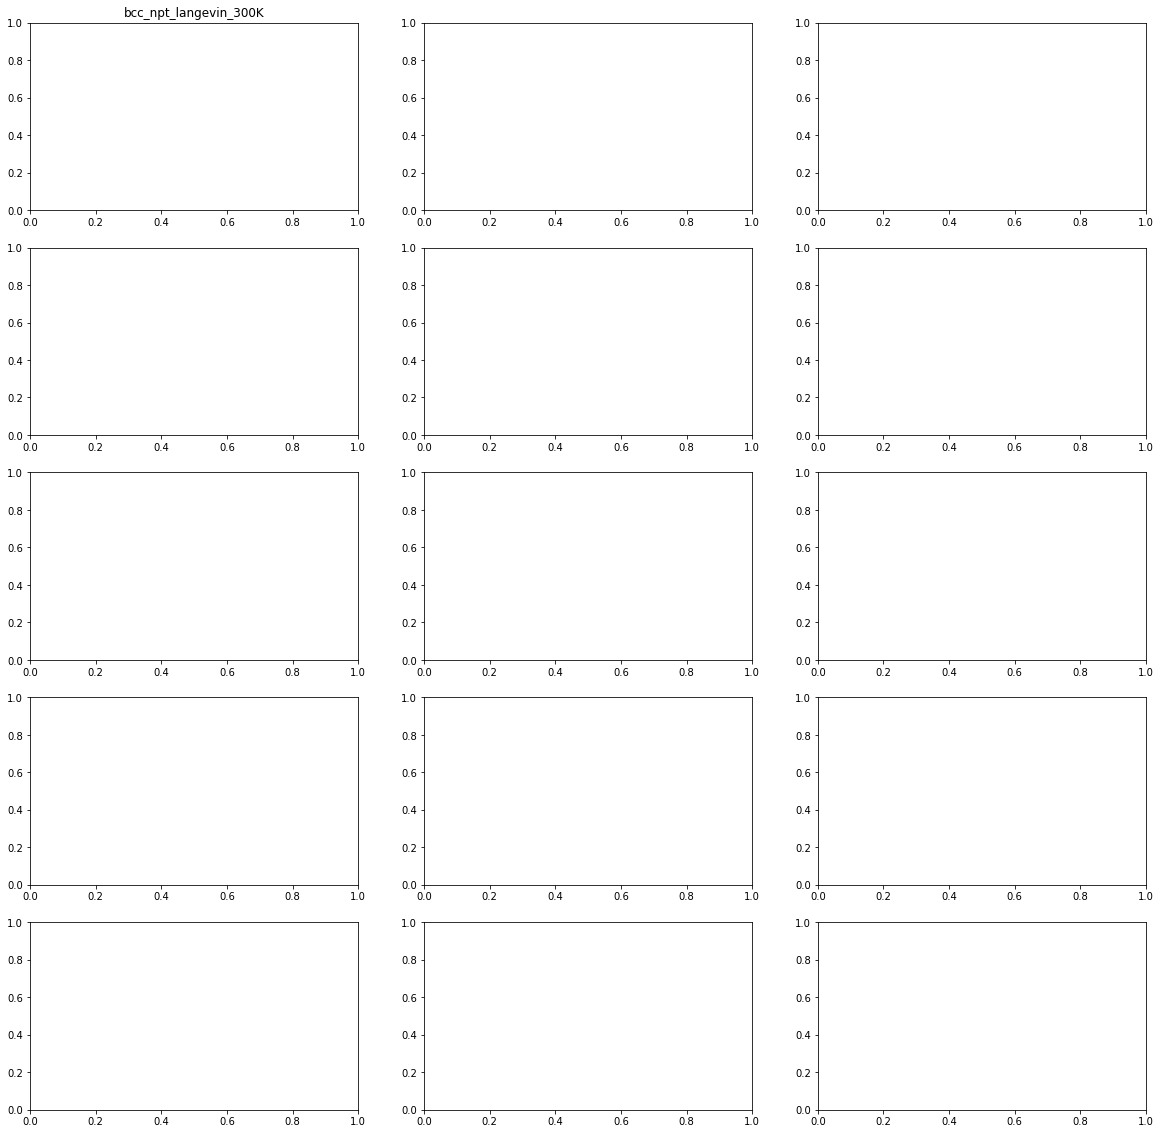

In [72]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20,20))
    
for k, trj in enumerate(tkeys):
        
    i, j = divmod(k, 3)

    axes[i,j].set_title(trj)
        
#    axes[i,j].plot(X.dot(b_lamb), 'b--', lw=2, label='sd/lambda')
#    axes[i,j].plot(X.dot(b_ext), 'g--', lw=2, label='x')
    rr = list(range(bounds[k][0], bounds[k][1]))

#     axes[i,j].plot(rr, Xall.dot(b_weight11)[bounds[k][0]:bounds[k][1]], 'r.--', lw=2, label='weight')
    axes[i,j].plot(rr, Xallx.dot(b_all)[bounds[k][0]:bounds[k][1]], 'b.--', lw=2, label='weight')
#     axes[i,j].plot(rr, Xallx.dot(b_weight8)[bounds[k][0]:bounds[k][1]], 'g.--', lw=2, label='weight')
#     axes[i,j].plot(rr, Xallx.dot(b_weight9)[bounds[k][0]:bounds[k][1]], 'm.--', lw=2, label='weight')
    #axes[i,j].plot(rr, Xall.dot(b_init)[bounds[k][0]:bounds[k][1]], 'y.--', lw=2, label='weight')

    axes[i,j].plot(rr, yallx[bounds[k][0]:bounds[k][1]], 'k.--', lw=2, label='target')
    axes[i,j].legend()
    
    if trj == 'relax':
        axes[i,j].set_ylim(-1195, -1125)
    if trj == 'eos':
        axes[i,j].set_ylim(-1195, -800)
        axes[i,j].set_xlim(1395,1410)
        
    #axes[i,j].set_xlim(*bounds[k][0])
    #axes[i,j].set_ylim(*bounds[k][1])

plt.tight_layout()

In [816]:
stats_file = 'stats_bs_samples' # 'stats_samples'
with open(os.path.join(working, stats_file+'.pickle'), 'rb') as fi:
    stats_tpf = pickle.load(fi)

stats_bspline = tpf_to_bsplines(stats_tpf)

target_file = 'target_bs_samples'
with open(os.path.join(working, target_file+'.pickle'), 'rb') as fi:
    targets = pickle.load(fi)

len 50


In [817]:
len(stats_tpf['relax']['energy'][0][2]), len(stats_bspline['relax']['energy'][0][2])

(50, 46)

In [818]:
for key in targets.keys():
    targets[key]['weight'] = 1.0

In [819]:
mb_knots = list(np.linspace(3.75, 5.25, 16))
pair_knots = list(np.linspace(1.05, 5.25, 43))
#pair_knots = list(np.linspace(2.05, 5.25, 33))

print(mb_knots)
print(pair_knots)

# Select knots for optimization
# cycle over knots of selected models
stats_list = []
for knot in mb_knots:
    edens_knots = [knot]
    stats = downselect(stats_bspline, pair_knots, edens_knots)
    stats_list.append(stats)

[3.75, 3.85, 3.95, 4.05, 4.15, 4.25, 4.35, 4.45, 4.55, 4.65, 4.75, 4.85, 4.95, 5.05, 5.15, 5.25]
[1.05, 1.1500000000000001, 1.25, 1.35, 1.4500000000000002, 1.55, 1.6500000000000001, 1.75, 1.85, 1.9500000000000002, 2.05, 2.1500000000000004, 2.25, 2.35, 2.45, 2.55, 2.6500000000000004, 2.75, 2.85, 2.95, 3.05, 3.1500000000000004, 3.25, 3.3500000000000005, 3.45, 3.55, 3.6500000000000004, 3.75, 3.8500000000000005, 3.95, 4.05, 4.15, 4.25, 4.3500000000000005, 4.45, 4.55, 4.65, 4.75, 4.8500000000000005, 4.95, 5.05, 5.15, 5.25]


In [820]:
for i, stat in enumerate(stats_list[-1:]):
    Xall, yall, weights, beta, bounds = make_sd_matrices(targets, stat, keytrj=tkeys)

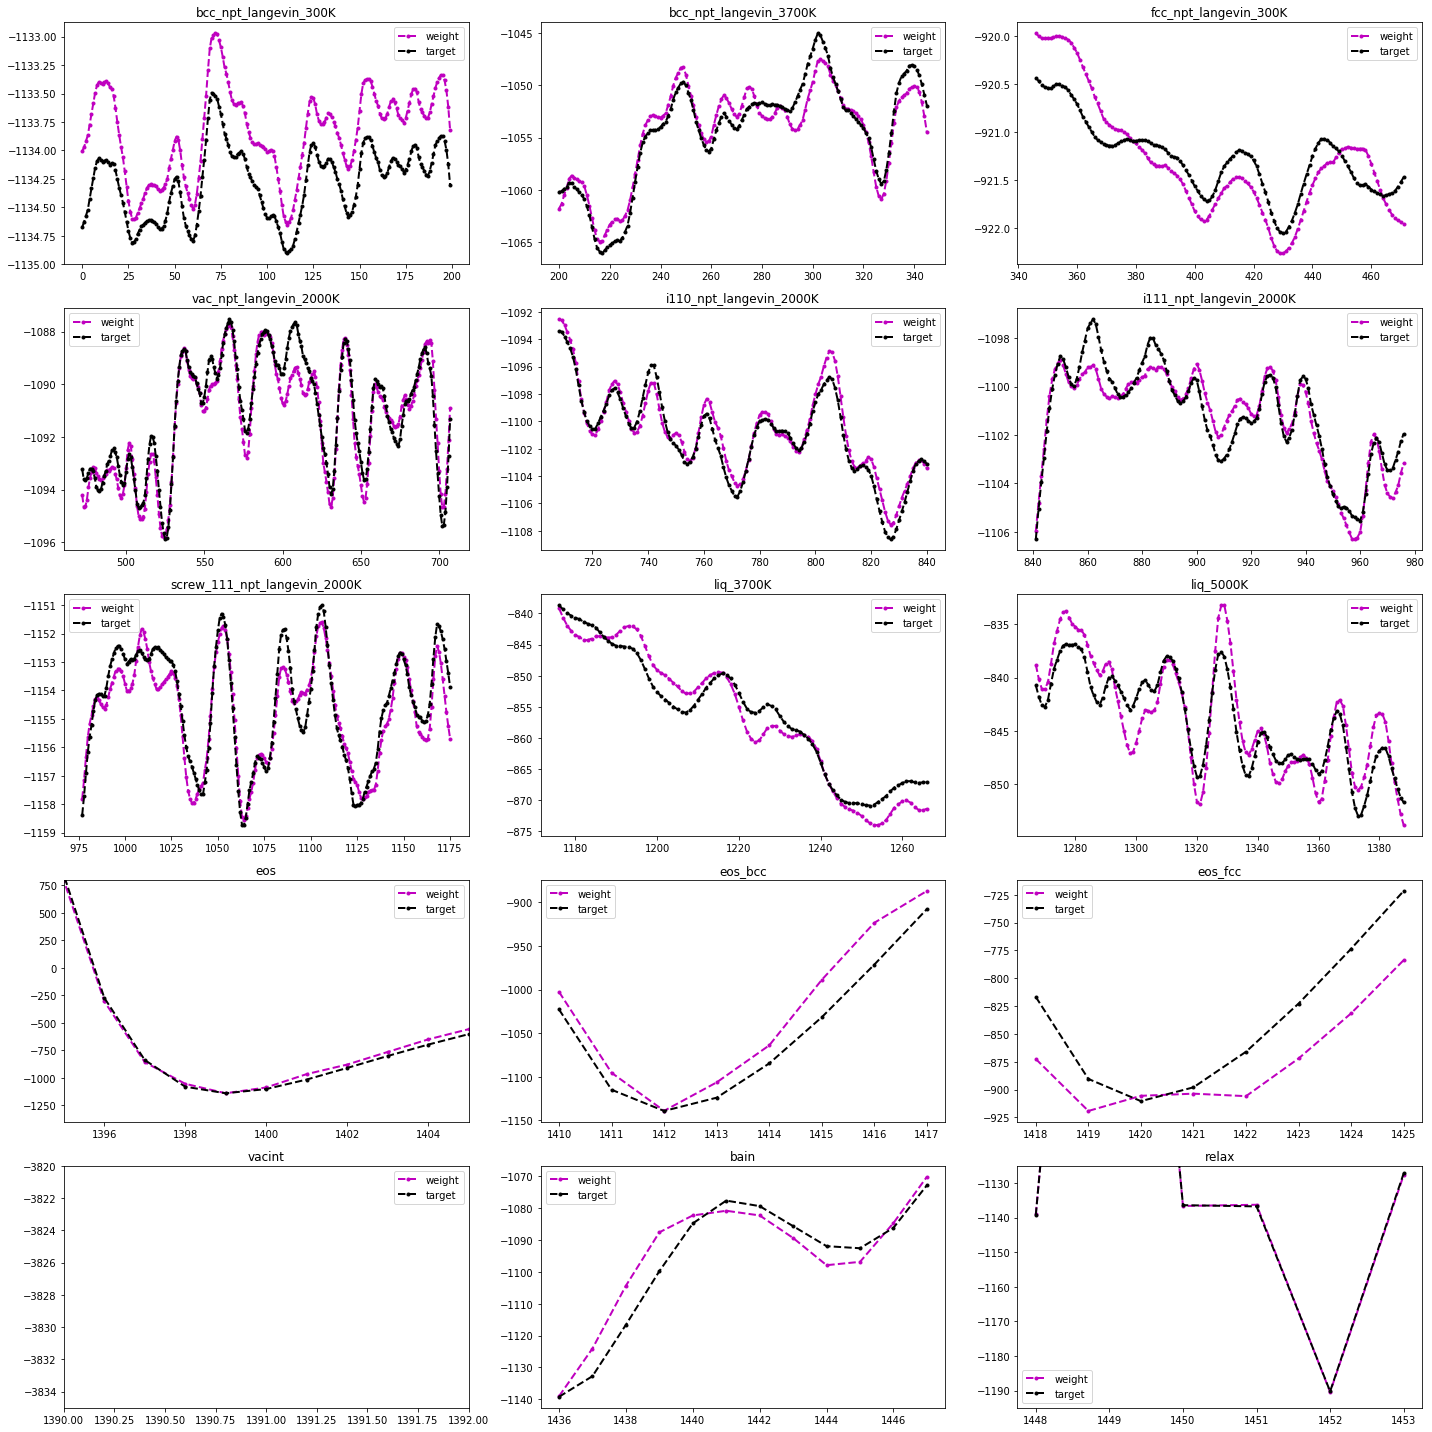

In [822]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20,20))
    
for k, trj in enumerate(tkeys):
        
    i, j = divmod(k, 3)

    axes[i,j].set_title(trj)
        
#    axes[i,j].plot(X.dot(b_lamb), 'b--', lw=2, label='sd/lambda')
#    axes[i,j].plot(X.dot(b_ext), 'g--', lw=2, label='x')
    rr = list(range(bounds[k][0], bounds[k][1]))

#     axes[i,j].plot(rr, Xall.dot(b_weight11)[bounds[k][0]:bounds[k][1]], 'r.--', lw=2, label='weight')
#     axes[i,j].plot(rr, Xallx.dot(b_weight7)[bounds[k][0]:bounds[k][1]], 'b.--', lw=2, label='weight')
#     axes[i,j].plot(rr, Xallx.dot(b_weight8)[bounds[k][0]:bounds[k][1]], 'g.--', lw=2, label='weight')
    axes[i,j].plot(rr, Xall.dot(b_all)[bounds[k][0]:bounds[k][1]], 'm.--', lw=2, label='weight')
    #axes[i,j].plot(rr, Xall.dot(b_init)[bounds[k][0]:bounds[k][1]], 'y.--', lw=2, label='weight')

    axes[i,j].plot(rr, yall[bounds[k][0]:bounds[k][1]], 'k.--', lw=2, label='target')
    axes[i,j].legend()
    
    if trj == 'relax':
        axes[i,j].set_ylim(-1195, -1125)
        
    if trj == 'vacint':
        axes[i,j].set_ylim(-3835, -3820)
        axes[i,j].set_xlim(1390,1392)
        
    if trj == 'eos':
        axes[i,j].set_ylim(-1400, 800)
        axes[i,j].set_xlim(1395,1405)
        
    #axes[i,j].set_xlim(*bounds[k][0])
    #axes[i,j].set_ylim(*bounds[k][1])

plt.tight_layout()

In [504]:
p_knots = np.array(pair_knots)+0.4
p_knots

array([1.45, 1.55, 1.65, 1.75, 1.85, 1.95, 2.05, 2.15, 2.25, 2.35, 2.45,
       2.55, 2.65, 2.75, 2.85, 2.95, 3.05, 3.15, 3.25, 3.35, 3.45, 3.55,
       3.65, 3.75, 3.85, 3.95, 4.05, 4.15, 4.25, 4.35, 4.45, 4.55, 4.65,
       4.75, 4.85, 4.95, 5.05, 5.15, 5.25, 5.35, 5.45, 5.55, 5.65])

In [505]:
def _bspline_coeffs_to_tpf(n_tot):
    """
    Finds b-spline coefficients reproducing a single cubic
    functin (rc-r)**3
    """

    penalty = [1.0, -4.0, 6.0, -4.0, 1.0]
    o = 4
    P = np.zeros((n_tot+4, n_tot), dtype=float)
    for i in range(n_tot+4):
        #ii = i - 4
        for j, p in enumerate(penalty):
            if i+j-o < 0 or i+j-o > n_tot-1:
                continue
            P[i, i+j-o] = p

    return P

In [506]:
M = _bspline_coeffs_to_tpf(43)

In [507]:
#b11_ext = np.array([4.2e3, 3.6e3, 3.10e3, 2.65e3] + list(b_weight11[2:]))*(6*0.1**3)
b11_ext = np.array(list(b_all[2:]))#*(6*0.1**3)
print(b11_ext)
tpf_coeff = M.dot(b11_ext)
print(tpf_coeff)

[ 4.22824426e+03  3.54009480e+03  2.91119261e+03  2.34153772e+03
  1.83113026e+03  1.37997039e+03  9.88058321e+02  6.55394274e+02
  3.81978459e+02  1.67811053e+02  1.24862009e+01 -8.79627304e+01
 -1.43545176e+02 -1.67016514e+02 -1.68316234e+02 -1.58859588e+02
 -1.52245978e+02 -1.41522891e+02 -1.31799084e+02 -1.24427156e+02
 -1.07866113e+02 -8.29740112e+01 -6.06836589e+01 -4.81849563e+01
 -4.36744378e+01 -3.91472388e+01 -3.22134949e+01 -2.58537638e+01
 -2.26912671e+01 -2.12961404e+01 -2.06873517e+01 -1.86526528e+01
 -1.45559864e+01 -1.10689543e+01 -8.78888460e+00 -5.32464713e+00
 -1.32322585e+00  9.00599115e-01  1.19455876e+00  1.38108240e+00
 -4.40635093e-01 -1.37195754e+00 -1.22719835e+00]
[ 4.22824426e+03 -1.33728823e+04  1.41202790e+04 -4.97564098e+03
  9.10758972e-05  5.38825989e-05  3.86238098e-05  5.24520874e-06
 -2.62260437e-06 -3.64780426e-05 -4.06030059e-01 -3.56078100e+00
 -6.04279995e+00 -2.74594337e+00  2.81588787e+00 -1.47576168e+00
 -2.18415010e+00  2.05519152e+01 -1.2061

In [508]:
p_knot = [1.05, 1.15, 1.25, 1.35] + list(p_knots)
len(tpf_coeff), len(p_knot)

(47, 47)

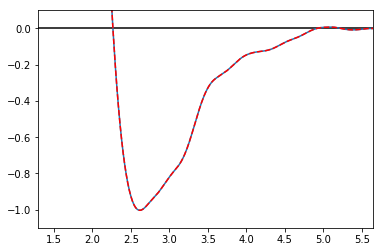

In [517]:
from statmechlib.forcefields import f_embed, f_dens, f_spline3

rr = np.linspace(1.3, 5.65, 436)

plt.plot(rr, [make_bspline(b_all[2:], p_knot, r) for r in rr])
plt.xlim(1.3,)

#print(rr)
bs_target = [make_bspline(b_all[2:], p_knot, r) for r in rr]
plt.plot(rr, [f_spline3(r, tpf_coeff, p_knot) for r in rr], 'r--')
plt.ylim(-1.1,0.1)
plt.xlim(rr[0], rr[-1])
plt.hlines(0.0, rr[0], rr[-1])
plt.savefig('pair_potential')

In [513]:
tpf_coeff

array([ 4.22824426e+03, -1.33728823e+04,  1.41202790e+04, -4.97564098e+03,
        9.10758972e-05,  5.38825989e-05,  3.86238098e-05,  5.24520874e-06,
       -2.62260437e-06, -3.64780426e-05, -4.06030059e-01, -3.56078100e+00,
       -6.04279995e+00, -2.74594337e+00,  2.81588787e+00, -1.47576168e+00,
       -2.18415010e+00,  2.05519152e+01, -1.20612704e+01,  3.75615722e+00,
        1.28935941e+01, -1.23990495e+01, -1.00747538e+01,  3.74290898e+00,
        8.99336571e+00,  6.20139912e+00, -5.61500046e+00, -5.37042186e+00,
        3.57335970e-01,  4.05308592e+00, -4.48832229e-01,  1.23121627e+00,
       -1.57619130e+00, -3.30765875e+00,  2.07427372e+00,  2.98845802e+00,
       -3.03811395e+00, -1.66779622e+00,  2.16251113e+00,  1.97469831e+00,
       -3.72323444e+00,  4.79944132e+00, -2.71294960e+00, -1.79329082e-01,
       -2.31599501e+00,  3.53683585e+00, -1.22719835e+00])

In [516]:
print('pair')

for c, k in zip(tpf_coeff, p_knot):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))

print('edens') 
for c, k in zip([1.0], [5.25]):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
        
print('embed')
#print(-4.42166597e-01,  1.12818607e-04)
print(-4.49779872e-01,  1.09664665e-04)

pair
+4228.2442627d0*(1.05d0 - r)**3*H(1.05d0 - r)
-13372.8822546d0*(1.15d0 - r)**3*H(1.15d0 - r)
+14120.2789984d0*(1.25d0 - r)**3*H(1.25d0 - r)
-4975.64097977d0*(1.35d0 - r)**3*H(1.35d0 - r)
+9.10758972168e-05d0*(1.45d0 - r)**3*H(1.45d0 - r)
+5.3882598877e-05d0*(1.55d0 - r)**3*H(1.55d0 - r)
+3.86238098145e-05d0*(1.65d0 - r)**3*H(1.65d0 - r)
+5.24520874023e-06d0*(1.75d0 - r)**3*H(1.75d0 - r)
-2.62260437012e-06d0*(1.85d0 - r)**3*H(1.85d0 - r)
-3.64780426025e-05d0*(1.95d0 - r)**3*H(1.95d0 - r)
-0.406030058861d0*(2.05d0 - r)**3*H(2.05d0 - r)
-3.56078100204d0*(2.15d0 - r)**3*H(2.15d0 - r)
-6.04279994965d0*(2.25d0 - r)**3*H(2.25d0 - r)
-2.74594336748d0*(2.35d0 - r)**3*H(2.35d0 - r)
+2.8158878684d0*(2.45d0 - r)**3*H(2.45d0 - r)
-1.4757616818d0*(2.55d0 - r)**3*H(2.55d0 - r)
-2.18415009975d0*(2.65d0 - r)**3*H(2.65d0 - r)
+20.5519151688d0*(2.75d0 - r)**3*H(2.75d0 - r)
-12.061270386d0*(2.85d0 - r)**3*H(2.85d0 - r)
+3.75615721941d0*(2.95d0 - r)**3*H(2.95d0 - r)
+12.893594116d0*(3.05d0 - r)**3*H(3

In [ ]:
par = param_list[2]
print('pair')
for c, k in zip(par['params']['pair'], par['hyperparams']['pair']):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
print('edens')   
for c, k in zip(par['params']['edens'], par['hyperparams']['edens']):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
print('embed')    
par['params']['embed']

Parameters given to Yuri:

Embedding:
-4.42166597e-01,  1.12818607e-04,
Pair potential coefficients: Knots ending at 5.65 with steps of 0.1 A:

4.51698420e+03,  3.75910139e+03, 3.06924350e+03,  2.44738802e+03,  1.89346739e+03,  1.40738478e+03,
9.89029865e+02,  6.38294633e+02,  3.55089127e+02,  1.39357269e+02,
       -9.60824592e+00, -9.86104306e+01, -1.44135463e+02, -1.65813774e+02,
       -1.73239670e+02, -1.65893890e+02, -1.60198554e+02, -1.46418160e+02,
       -1.35762684e+02, -1.25923736e+02, -1.10532902e+02, -8.90260796e+01,
       -6.86880677e+01, -5.45283774e+01, -4.52604866e+01, -3.77851927e+01,
       -3.19692325e+01, -2.76892221e+01, -2.45864649e+01, -2.09702658e+01,
       -1.96949536e+01, -2.16298673e+01, -1.49970585e+01, -9.26360379e+00,
       -1.22233430e+01, -5.85168131e+00,  1.60207091e+00,  3.86904582e+00,
       -2.36332511e+00,  2.69685169e+00, -1.92552950e+00, -5.24093457e-01,
        1.38798423e-01